#Bike_Sharing Problematic

### **Introduction to the Problematic**

Bike-sharing systems have emerged as a sustainable and efficient solution for urban transportation, addressing the growing need for eco-friendly mobility options. These systems allow users to rent bikes from one station and return them to another, providing flexibility and reducing traffic congestion. However, managing the supply and demand of bikes across stations remains a significant challenge for operators. Imbalances in bike availability—such as overcrowded or empty stations—can lead to user dissatisfaction and increased operational costs.

Accurately predicting bike-sharing demand is crucial for optimizing bike distribution, ensuring a seamless user experience, and minimizing operational inefficiencies. By leveraging historical data, operators can anticipate demand patterns and make informed decisions about bike allocation, maintenance, and station placement.

This project focuses on developing a deep learning model to predict bike-sharing demand for the next 60 minutes at each station. The goal is to provide actionable insights that can enhance the efficiency of bike-sharing systems, improve user satisfaction, and support sustainable urban mobility.

---


In [119]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning (Keras/TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Handling
from datetime import datetime, timedelta

# Geospatial Data (Optional)
import folium  # For mapping stations
import plotly.express as px

# Miscellaneous
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Bike_sharing Problematic/online exam.csv', parse_dates=['started_at', 'ended_at'])
df.head()

ride_id  rideable_type              started_at  \
0  28A17ACD224CD80B  electric_bike 2024-12-06 17:50:49.428   
1  3508393A86FBD357   classic_bike 2024-12-14 11:01:00.309   
2  75FA4C03A1447401  electric_bike 2024-12-24 08:07:17.475   
3  C7741EF495C597DD   classic_bike 2024-12-19 12:48:05.452   
4  07952BB20B46C5B1  electric_bike 2024-12-17 11:19:37.631   

                 ended_at start_station_name start_station_id  \
0 2024-12-06 17:54:20.070        Oakland Ave            JC022   
1 2024-12-14 11:12:01.382        Oakland Ave            JC022   
2 2024-12-24 08:14:14.612        Oakland Ave            JC022   
3 2024-12-19 12:54:15.253        Oakland Ave            JC022   
4 2024-12-17 11:28:25.150        Oakland Ave            JC022   

                           end_station_name end_station_id  start_lat  \
0                                   Hilltop          JC019  40.737604   
1  Hoboken Terminal - Hudson St & Hudson Pl          HB101  40.737604   
2                       Leonard Gordon Park          JC080  40.737604   
3                       Leonard Gordon Park          JC080  40.737604   
4                             Grove St PATH          JC115  40.737604   

   start_lng    end_lat    end_lng member_casual  
0 -74.052478  40.731169 -74.057574        member  
1 -74.052478  40.735938 -74.030305        member  
2 -74.052478  40.745910 -74.057271        member  
3 -74.052478  40.745910 -74.057271        member  
4 -74.052478  40.719410 -74.043090        casual

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54833 entries, 0 to 54832
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             54833 non-null  object        
 1   rideable_type       54833 non-null  object        
 2   started_at          54833 non-null  datetime64[ns]
 3   ended_at            54833 non-null  datetime64[ns]
 4   start_station_name  54833 non-null  object        
 5   start_station_id    54833 non-null  object        
 6   end_station_name    54709 non-null  object        
 7   end_station_id      54667 non-null  object        
 8   start_lat           54833 non-null  float64       
 9   start_lng           54833 non-null  float64       
 10  end_lat             54817 non-null  float64       
 11  end_lng             54817 non-null  float64       
 12  member_casual       54833 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(7)
me

In [5]:
# Check for null values in each column
null_counts = df.isnull().sum()
print(null_counts)

# Check the total number of null values in the DataFrame
total_nulls = df.isnull().sum().sum()
print(f"\nTotal number of null values: {total_nulls}")

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name      124
end_station_id        166
start_lat               0
start_lng               0
end_lat                16
end_lng                16
member_casual           0
dtype: int64

Total number of null values: 322


In [4]:
df['start_station_name'].value_counts()

start_station_name
Hoboken Terminal - River St & Hudson Pl     3296
Grove St PATH                               2678
Hoboken Terminal - Hudson St & Hudson Pl    1424
Bergen Ave & Sip Ave                        1362
City Hall - Washington St & 1 St            1359
                                            ... 
5 Corners Library                            150
Jackson Square                                87
Bergen Ave & Stegman St                       76
Union St                                      72
Grant Ave & MLK Dr                            28
Name: count, Length: 83, dtype: int64

In [6]:
# Earliest and latest ride start times
start_min = df['started_at'].min()
start_max = df['started_at'].max()

# Earliest and latest ride end times
end_min = df['ended_at'].min()
end_max = df['ended_at'].max()

print(f"Rides started between: {start_min} and {start_max}")
print(f"Rides ended between: {end_min} and {end_max}")

Rides started between: 2024-11-30 23:32:54.155000 and 2024-12-31 23:54:10.246000
Rides ended between: 2024-12-01 00:01:10.086000 and 2024-12-31 23:57:23.046000


In [7]:
# Calculate ride duration in minutes
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df[df['duration_min'] > 0]  # Remove invalid durations

###2. Temporal Analysis

Rides by Hour of Day

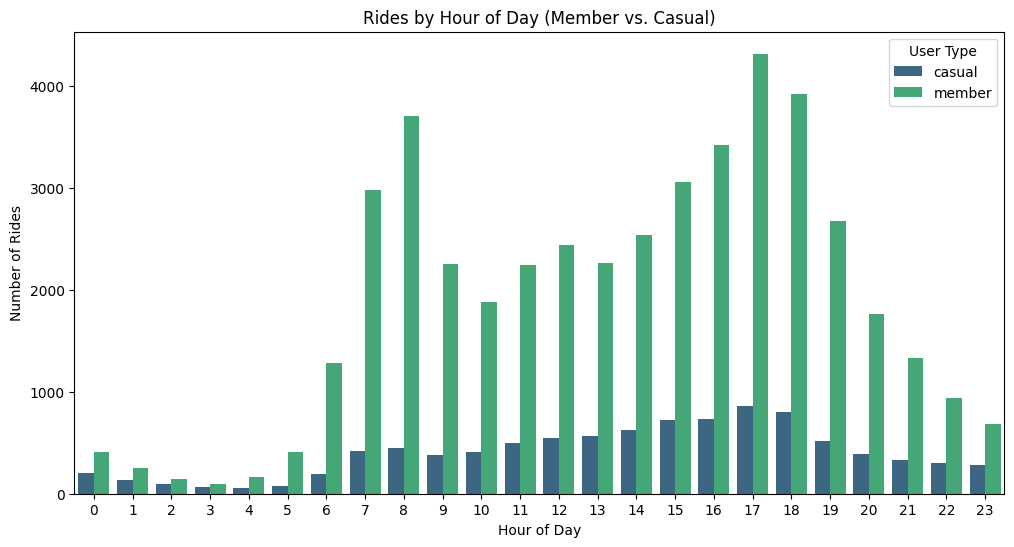

In [10]:
# Extract hour from start time
df['start_hour'] = df['started_at'].dt.hour

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_hour', hue='member_casual', palette='viridis')
plt.title('Rides by Hour of Day (Member vs. Casual)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.legend(title='User Type')
plt.show()

### **Analysis of "Rides by Hour of Day (Member vs. Casual)"**

1. **Peak Hours**: High activity for both groups during **7-9 AM** and **4-7 PM**, likely for commuting.
2. **Member vs. Casual**: Members ride more consistently, likely for daily commutes. Casual riders peak in **12 PM - 7 PM**, suggesting leisure use.
3. **Low Activity**: Minimal rides from **12 AM - 5 AM**.
4. **Implications**: Target casual riders for membership, redistribute bikes during peaks, and promote off-peak usage.



Rides by Day of Week

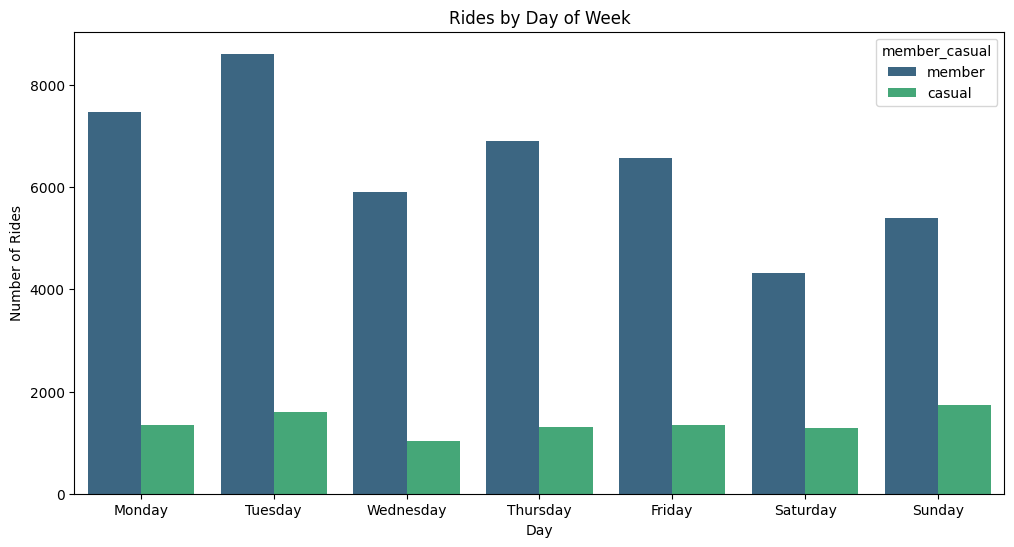

In [14]:
df['day_of_week'] = df['started_at'].dt.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='day_of_week', hue='member_casual', order=order, palette='viridis')
plt.title('Rides by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.show()

### **Analysis of "Rides by Day of Week"**

1. **Weekdays vs. Weekends**:
   - **Members** show higher usage on **weekdays (Monday-Friday)**, likely for commuting.
   - **Casual riders** peak on **weekends (Saturday-Sunday)**, suggesting leisure or recreational use.

2. **Usage Patterns**:
   - Members have consistent weekday usage, reflecting routine trips.
   - Casual riders have a noticeable spike on weekends, indicating event-driven or leisure activities.

3. **Implications**:
   - Focus on bike availability for members during weekdays.
   - Promote weekend offers or events to attract casual riders.

Peak Hours Comparison (Members vs. Casual)

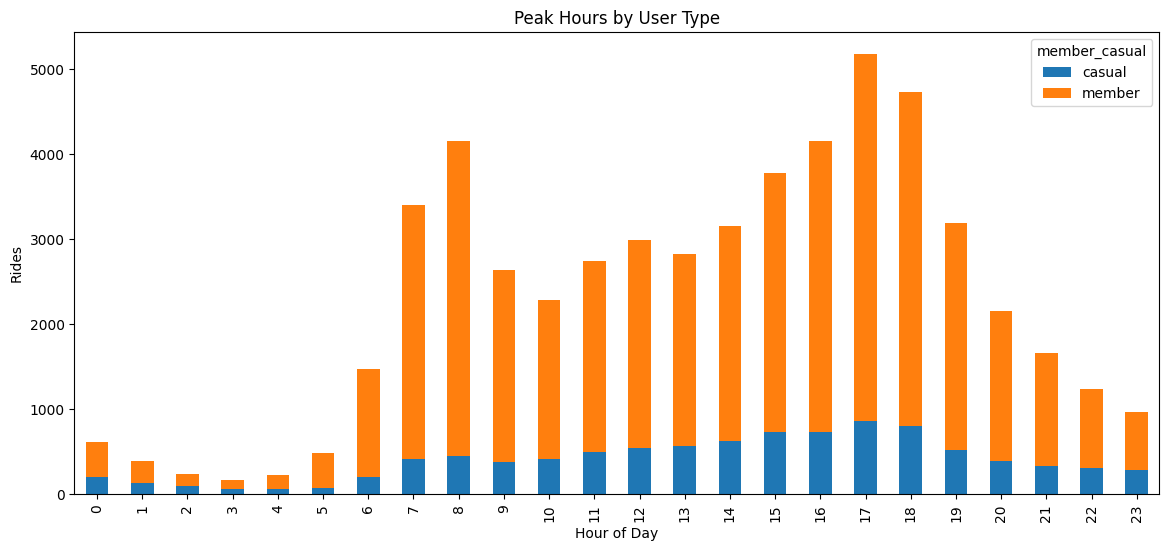

In [13]:
peak_hours = df.groupby(['start_hour', 'member_casual']).size().unstack()
peak_hours.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Peak Hours by User Type')
plt.xlabel('Hour of Day')
plt.ylabel('Rides')
plt.show()

### **Analysis of "Peak Hours by User Type"**

1. **Peak Hours**:
   - Both **members** and **casual riders** show high activity during **7-9 AM** and **4-7 PM**, aligning with commuting times.

2. **Usage Differences**:
   - **Members** have higher overall usage, especially during peak hours, indicating regular commuting.
   - **Casual riders** show a smaller peak during midday and evening, suggesting leisure or occasional use.

3. **Implications**:
   - Ensure sufficient bike availability during peak commuting hours for members.
   - Consider targeted promotions for casual riders during midday to boost usage.

Weekend vs. Weekday Usage

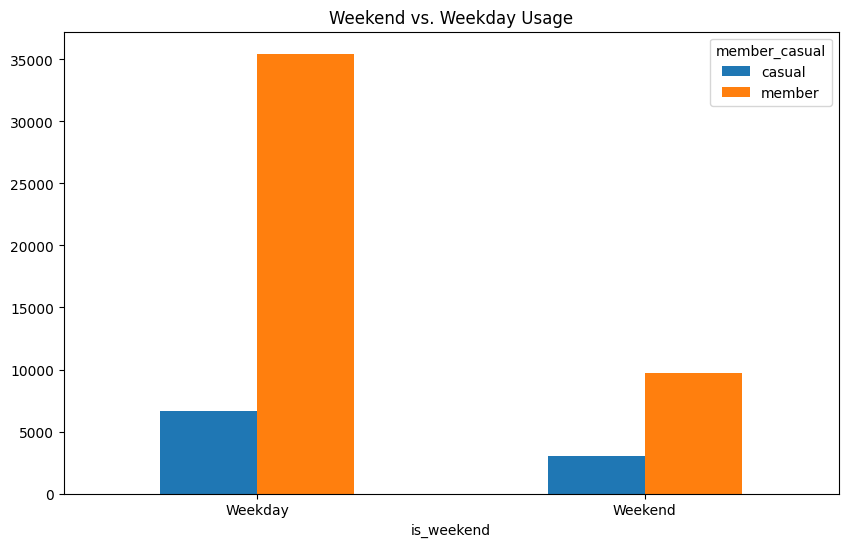

In [14]:
df['is_weekend'] = df['started_at'].dt.dayofweek >= 5  # 5=Sat, 6=Sun
weekend_usage = df.groupby(['is_weekend', 'member_casual']).size().unstack()
weekend_usage.plot(kind='bar', figsize=(10, 6))
plt.title('Weekend vs. Weekday Usage')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.show()

### **Analysis of "Weekend vs. Weekday Usage"**

1. **Usage Patterns**:
   - **Members** have higher usage on **weekdays**, likely for daily commuting.
   - **Casual riders** show a significant increase on **weekends**, indicating leisure or recreational use.

2. **Behavioral Insights**:
   - Members rely on the service consistently during weekdays.
   - Casual riders prefer weekends for biking, possibly for leisure or social activities.

3. **Implications**:
   - Focus on bike availability for members during weekdays.
   - Promote weekend offers or events to attract casual riders and balance demand.

###3. User Behavior

User Type Distribution

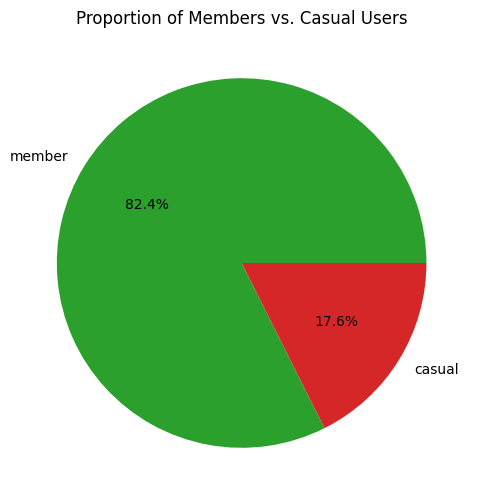

In [15]:
plt.figure(figsize=(6, 6))
df['member_casual'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#2ca02c', '#d62728'])
plt.title('Proportion of Members vs. Casual Users')
plt.ylabel('')
plt.show()

### **Analysis of "Proportion of Members vs. Casual Users"**

1. **User Distribution**:
   - **Members** make up **82.4%** of users, indicating a strong base of regular, likely commuter users.
   - **Casual users** account for **17.6%**, representing a smaller but still significant group, possibly using the service for leisure or occasional trips.

2. **Implications**:
   - Focus on retaining and expanding the member base, as they are the primary users.
   - Develop strategies to convert casual users into members, such as loyalty programs or discounted memberships.
   - Tailor marketing efforts to attract more casual users, especially during weekends and off-peak hours.

Ride Duration Comparison

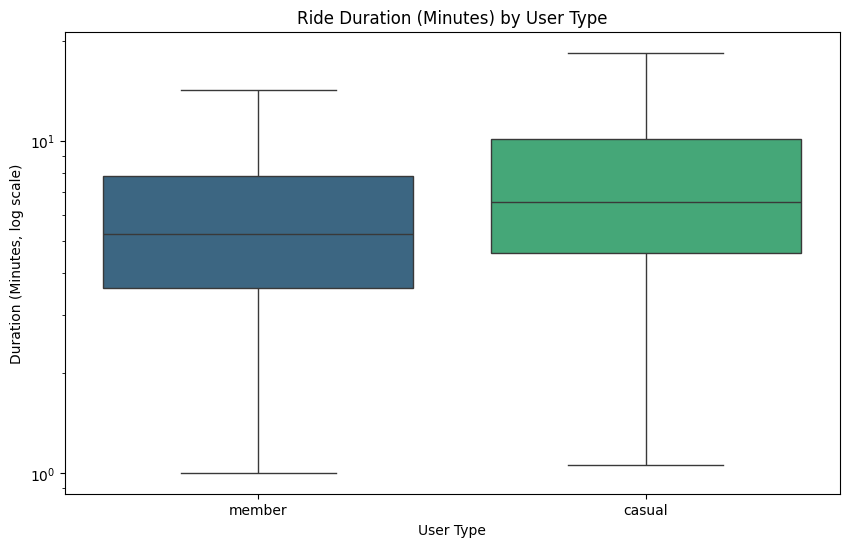

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='member_casual', y='duration_min', showfliers=False, palette='viridis')
plt.yscale('log')  # Handle outliers
plt.title('Ride Duration (Minutes) by User Type')
plt.xlabel('User Type')
plt.ylabel('Duration (Minutes, log scale)')
plt.show()

### **Analysis of "Ride Duration (Minutes) by User Type"**

1. **Ride Duration**:
   - **Casual users** tend to have longer ride durations compared to **members**.
   - **Members** show shorter, more consistent ride times, likely due to regular commuting.

2. **Behavioral Insights**:
   - Casual users may use bikes for leisure or longer trips, such as sightseeing or recreational activities.
   - Members likely use bikes for shorter, routine trips like commuting to work or school.

3. **Implications**:
   - Consider offering longer-duration plans or promotions for casual users to cater to their usage patterns.
   - Ensure bike availability and maintenance for members during peak commuting times to support their shorter, frequent trips.

Long-Ride Analysis (>60 mins)

Long rides (>1h): 245 (0.4% of total)


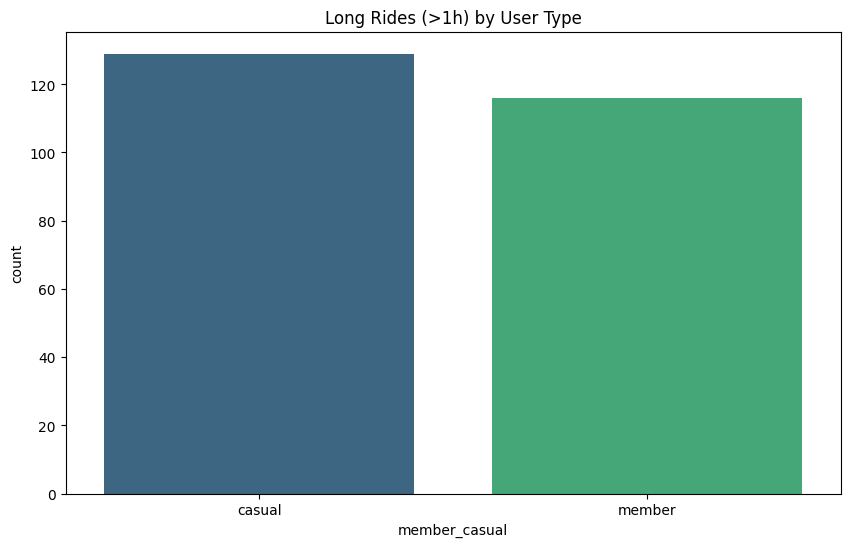

In [16]:

long_rides = df[df['duration_min'] > 60]
print(f"Long rides (>1h): {len(long_rides)} ({len(long_rides)/len(df)*100:.1f}% of total)")
plt.figure(figsize=(10, 6))
sns.countplot(data=long_rides, x='member_casual', palette='viridis')
plt.title('Long Rides (>1h) by User Type')
plt.show()

### **Analysis of "Long Rides (>1h) by User Type"**

1. **Long Ride Distribution**:
   - **Casual users** dominate long rides (>1 hour), indicating they are more likely to use bikes for extended periods, possibly for leisure or sightseeing.
   - **Members** have significantly fewer long rides, aligning with their preference for shorter, routine trips like commuting.

2. **Behavioral Insights**:
   - Casual users may prioritize flexibility and longer usage times, while members focus on efficiency and shorter trips.

3. **Implications**:
   - Offer tailored plans or promotions for casual users to encourage longer rides, such as day passes or discounted rates for extended use.
   - Ensure bike availability and maintenance for casual users during weekends or peak leisure times to support their longer trips.

###4. Station Analysis

Top Start Stations

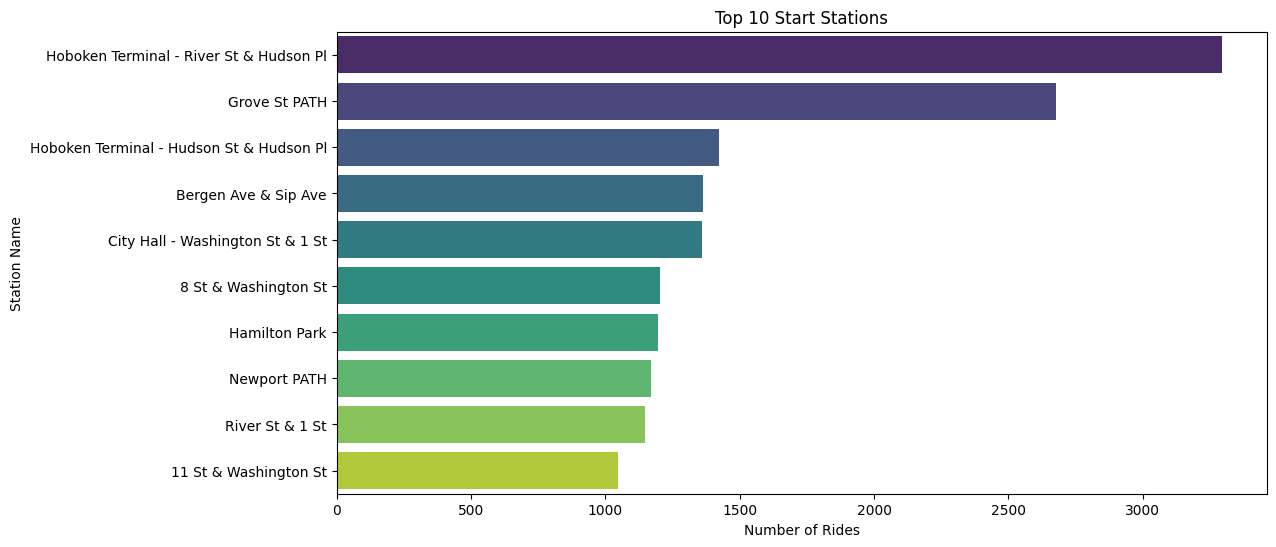

In [24]:
top_stations = df['start_station_name'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_stations.values, y=top_stations.index, palette='viridis')
plt.title('Top 10 Start Stations')
plt.xlabel('Number of Rides')
plt.ylabel('Station Name')
plt.show()

### **Analysis of "Top 10 Start Stations"**

1. **High-Demand Stations**:
   - **Holooken Terminal - River St & Hudson Pl** and **Holooken Terminal - Hudson St & Hudson Pl** are the most popular start stations, indicating high demand in these areas.
   - Other notable stations include **Bergen Ave & Sip Ave**, **City Hall - Washington St & 1 St**, and **8 St & Washington St**.

2. **Usage Patterns**:
   - These stations likely serve as key hubs for commuters, tourists, or popular destinations, leading to high bike pickup activity.

3. **Implications**:
   - Focus on maintaining sufficient bike availability at these high-demand stations to avoid shortages.
   - Consider expanding capacity or adding more bikes at these locations to meet user demand.
   - Analyze surrounding areas for potential new station placements to balance demand and improve service coverage.

In [17]:
start_counts = df['start_station_name'].value_counts().rename('start_count')
end_counts = df['end_station_name'].value_counts().rename('end_count')
station_diff = pd.concat([start_counts, end_counts], axis=1).fillna(0)
station_diff['difference'] = station_diff['start_count'] - station_diff['end_count']

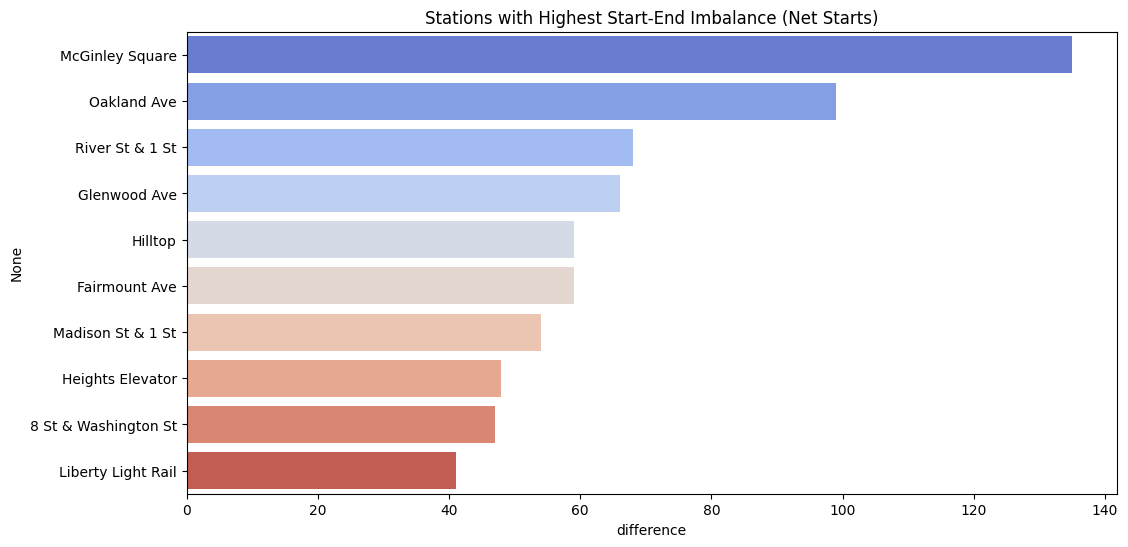

In [18]:
top_imbalance = station_diff.nlargest(10, 'difference')
plt.figure(figsize=(12, 6))
sns.barplot(y=top_imbalance.index, x=top_imbalance['difference'], palette='coolwarm')
plt.title('Stations with Highest Start-End Imbalance (Net Starts)')
plt.show()

### **Analysis of "Stations with Highest Start:End Imbalance (Net Starts)"**

1. **Imbalance Insights**:
   - **McGinley Square** and **Oakland Ave** show the highest net starts, indicating more bikes are being taken from these stations than returned.
   - Other stations like **River St & 1 St** and **Glemwood Ave** also exhibit significant imbalances.

2. **Behavioral Patterns**:
   - These stations are likely popular starting points for rides but not common destinations, leading to bike shortages.
   - Users may be commuting from these areas to other locations without returning bikes.

3. **Implications**:
   - Implement bike redistribution strategies to move bikes back to these stations during peak hours.
   - Consider incentives for users to return bikes to these locations, such as discounts or rewards.
   - Analyze surrounding areas to identify potential new stations or partnerships to balance bike distribution.

In [19]:
top_imbalance

start_count  end_count  difference
McGinley Square             693.0        558       135.0
Oakland Ave                 489.0        390        99.0
River St & 1 St            1149.0       1081        68.0
Glenwood Ave                234.0        168        66.0
Hilltop                     399.0        340        59.0
Fairmount Ave               359.0        300        59.0
Madison St & 1 St           983.0        929        54.0
Heights Elevator            239.0        191        48.0
8 St & Washington St       1205.0       1158        47.0
Liberty Light Rail          756.0        715        41.0

In [30]:
# Group by start-end station pairs and member_casual (corrected column name)
common_routes = df.groupby(['start_station_name', 'end_station_name', 'member_casual']).size().unstack(fill_value=0)

# Calculate total rides per route and sort
common_routes['total_rides'] = common_routes.sum(axis=1)
common_routes = common_routes.sort_values('total_rides', ascending=False).reset_index()

# Display top 10 routes
top_routes = common_routes.head(10)
top_routes[['start_station_name', 'end_station_name', 'casual', 'member', 'total_rides']]

member_casual                        start_station_name  \
0                                       McGinley Square   
1                                         Grove St PATH   
2                                         Grove St PATH   
3                                    Liberty Light Rail   
4              Hoboken Terminal - Hudson St & Hudson Pl   
5                                  8 St & Washington St   
6                                  Bergen Ave & Sip Ave   
7               Hoboken Terminal - River St & Hudson Pl   
8                                      Marin Light Rail   
9                                         Hamilton Park   

member_casual                         end_station_name  casual  member  \
0                                 Bergen Ave & Sip Ave      52     265   
1                                     Marin Light Rail      15     281   
2                                   Liberty Light Rail      27     258   
3                                        Grove St PATH      24     250   
4                           Hoboken Ave at Monmouth St     126     143   
5              Hoboken Terminal - River St & Hudson Pl      42     226   
6                                      McGinley Square      29     228   
7                                 8 St & Washington St      39     211   
8                                        Grove St PATH      15     232   
9                                        Grove St PATH      13     216   

member_casual  total_rides  
0                      317  
1                      296  
2                      285  
3                      274  
4                      269  
5                      268  
6                      257  
7                      250  
8                      247  
9                      229

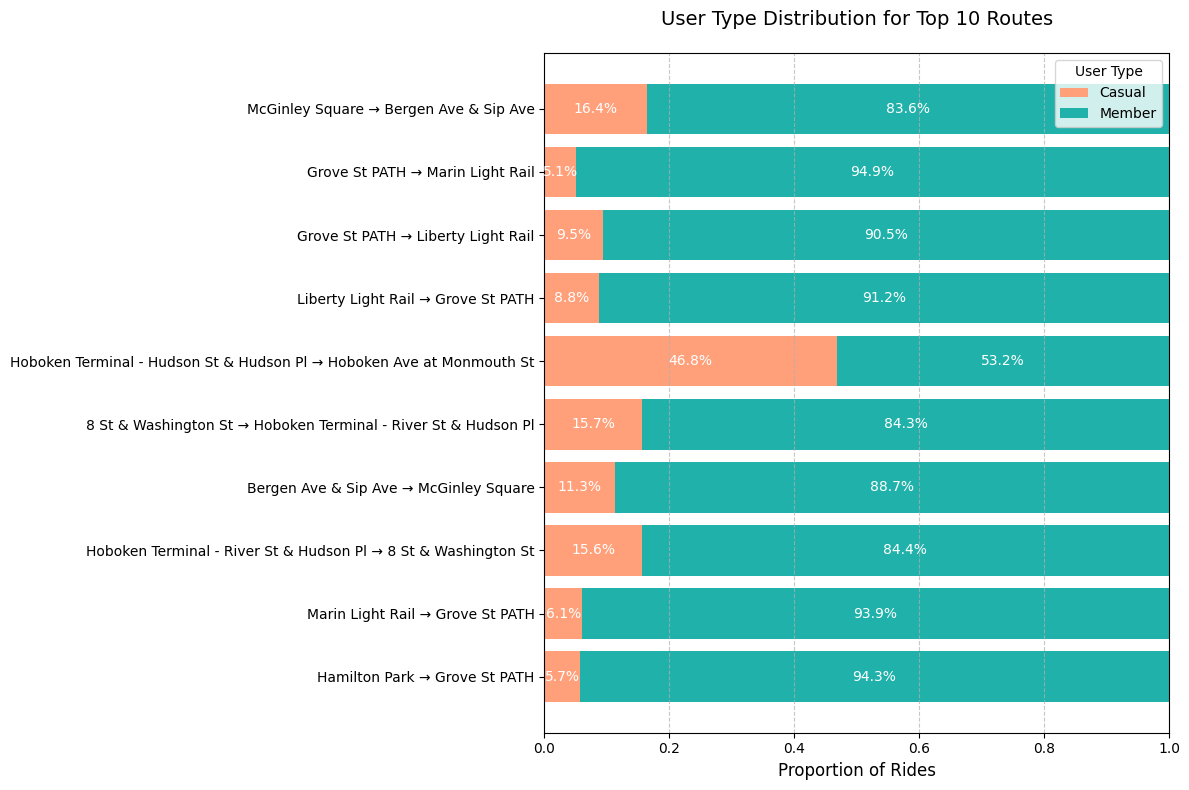

In [32]:
# Calculate percentages
top_routes['casual_pct'] = top_routes['casual'] / top_routes['total_rides']
top_routes['member_pct'] = top_routes['member'] / top_routes['total_rides']

# Create figure
plt.figure(figsize=(12, 8))

# Plot 100% stacked bars
plt.barh(top_routes['route'], top_routes['casual_pct'], label='Casual', color='#FFA07A')
plt.barh(top_routes['route'], top_routes['member_pct'], left=top_routes['casual_pct'],
         label='Member', color='#20B2AA')

# Add percentage labels
for i, (casual_pct, member_pct) in enumerate(zip(top_routes['casual_pct'], top_routes['member_pct'])):
    plt.text(casual_pct/2, i, f'{casual_pct:.1%}', ha='center', va='center', color='white')
    plt.text(casual_pct + member_pct/2, i, f'{member_pct:.1%}', ha='center', va='center', color='white')

# Customize plot
plt.title('User Type Distribution for Top 10 Routes', fontsize=14, pad=20)
plt.xlabel('Proportion of Rides', fontsize=12)
plt.xlim(0, 1)
plt.legend(title='User Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Analysis of "User Type Distribution for Top 10 Routes"**

1. **Route Usage**:
   - **Members** dominate most top routes, with proportions often exceeding **80%**, indicating these routes are heavily used for commuting or regular trips.
   - **Casual users** show higher proportions on routes like **Hoboken Terminal - Hudson St & Hudson PI – Hoboken Ave at Monmouth St (46.8%)**, suggesting these routes are popular for leisure or occasional trips.

2. **Behavioral Insights**:
   - Members prefer efficient, high-frequency routes, likely for daily commuting.
   - Casual users are more likely to use routes that may connect to tourist spots or leisure destinations.

3. **Implications**:
   - Focus on maintaining bike availability and service quality on member-dominated routes to support daily commuters.
   - Promote casual-friendly routes through marketing or partnerships to attract more leisure users.
   - Analyze underutilized routes to identify opportunities for increasing ridership among both user types.

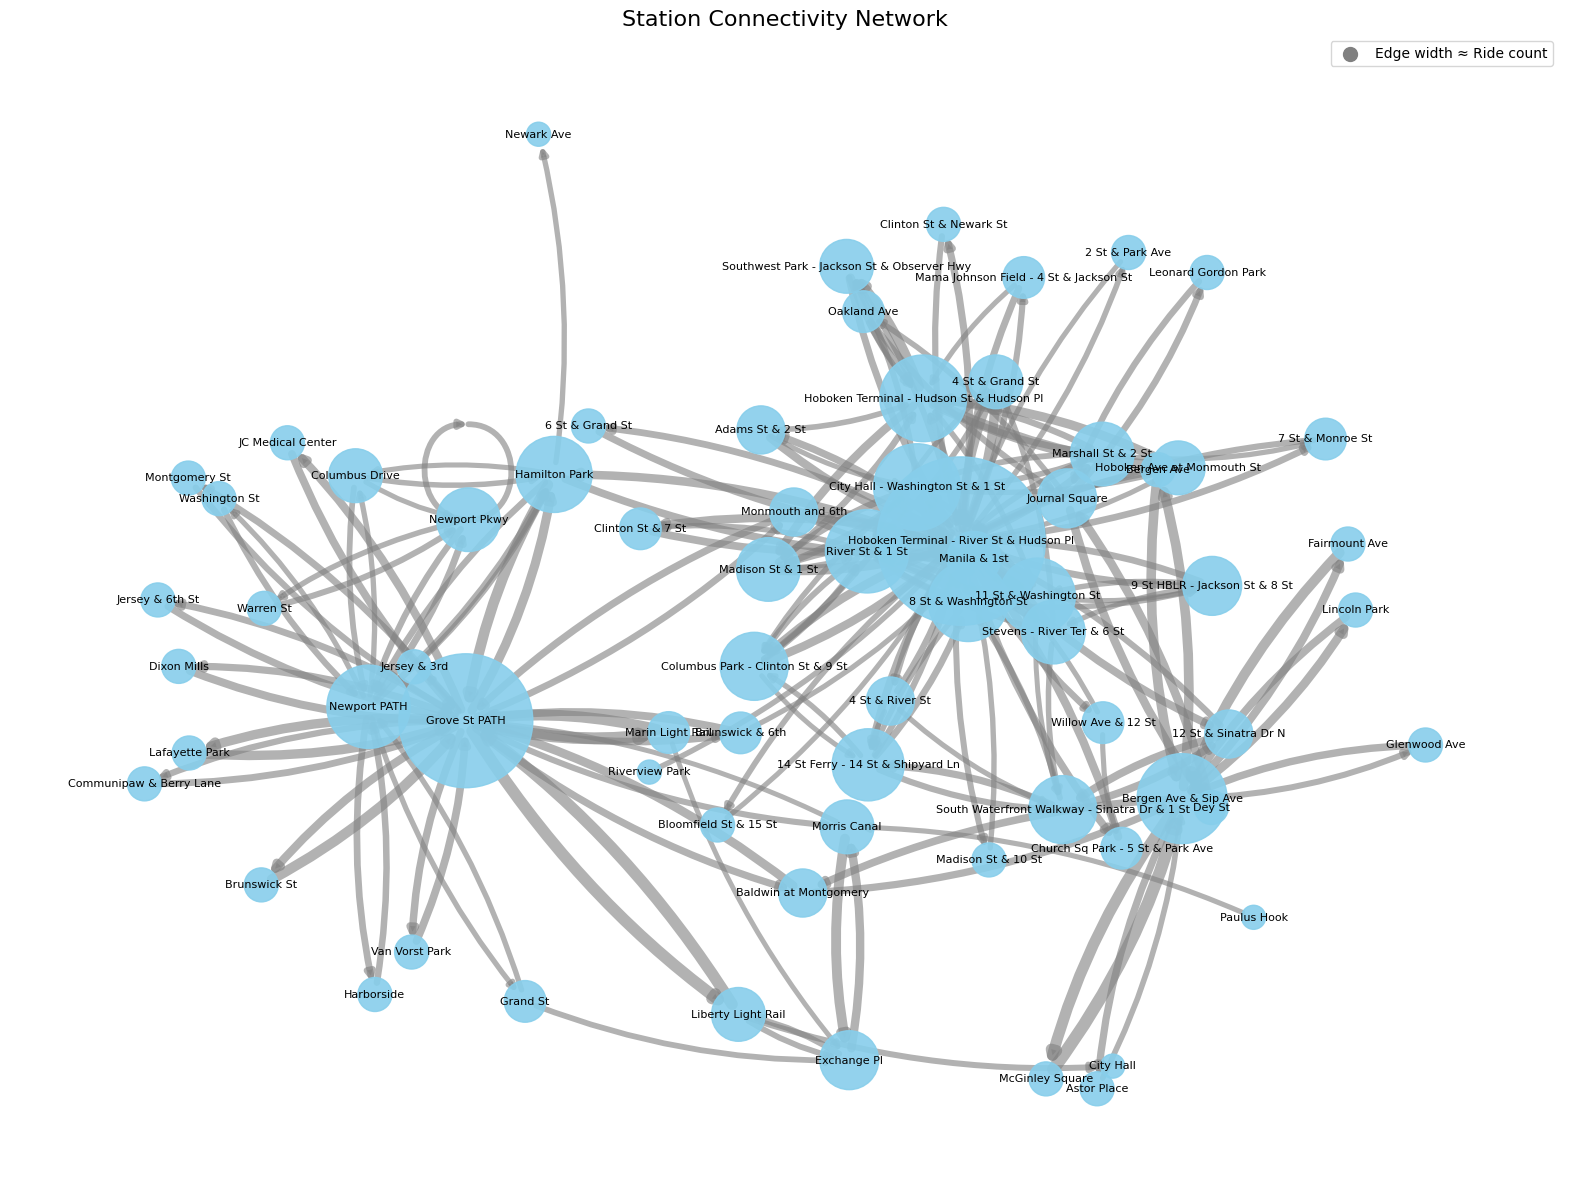

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# 1. Prepare connection data
station_connections = df.groupby(['start_station_name', 'end_station_name'])\
                       .size()\
                       .reset_index(name='ride_count')\
                       .sort_values('ride_count', ascending=False)

# 2. Filter top connections (adjust threshold as needed)
top_connections = station_connections[station_connections['ride_count'] > 50]  # Show routes with >50 rides

# 3. Create network graph
G = nx.from_pandas_edgelist(top_connections,
                           source='start_station_name',
                           target='end_station_name',
                           edge_attr='ride_count',
                           create_using=nx.DiGraph())  # Directed graph for start→end

# 4. Calculate node positions
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for spacing

# 5. Draw the network
plt.figure(figsize=(20, 15))

# Nodes (size by degree centrality)
node_sizes = [d * 300 for n, d in G.degree()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)

# Edges (width by ride count)
edge_widths = [0.5 * G[u][v]['ride_count']**(0.5) for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.6,
                      connectionstyle="arc3,rad=0.1")

# Labels (only for major stations)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title("Station Connectivity Network", fontsize=16)
plt.axis('off')

# Add legend for edge weights
plt.scatter([], [], c='gray', s=100, label='Edge width ≈ Ride count')
plt.legend(loc='upper right')

plt.show()

Hub Stations: Large nodes indicate stations with many connections

Key Routes: Thick lines represent high-traffic corridors

Directionality: Look for stations with many incoming vs outgoing arrows

Clusters: Groups of tightly connected stations indicate local neighborhoods

In [38]:
import networkx as nx
import pandas as pd

# Create directed graph from rides data
G = nx.from_pandas_edgelist(
    df,
    source='start_station_name',
    target='end_station_name',
    edge_attr=True,
    create_using=nx.DiGraph()  # Use DiGraph for directional relationships
)

# Calculate centrality metrics
centrality = {
    "Degree Centrality": nx.degree_centrality(G),
    "In-Degree Centrality": nx.in_degree_centrality(G),
    "Out-Degree Centrality": nx.out_degree_centrality(G),
    "Betweenness Centrality": nx.betweenness_centrality(G),
    "Closeness Centrality": nx.closeness_centrality(G),
    "Eigenvector Centrality": nx.eigenvector_centrality(G, max_iter=1000)
}

# Combine results into DataFrame
centrality_df = pd.DataFrame(centrality)
centrality_df.index.name = 'station'

In [40]:
# Normalize scores (0-1 range)
normalized_df = centrality_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create composite score (weighted average)
weights = {
    'Degree Centrality': 0.2,
    'Betweenness Centrality': 0.3,
    'Closeness Centrality': 0.2,
    'Eigenvector Centrality': 0.3
}
normalized_df['Composite Score'] = normalized_df[weights.keys()].dot(pd.Series(weights))

# Show top 10 central stations
top_stations = normalized_df.sort_values('Composite Score', ascending=False).head(10)

In [41]:
import plotly.express as px

# Prepare data for top station
sample_station = top_stations.index[0]
radar_df = normalized_df.loc[sample_station].reset_index()
radar_df.columns = ['Metric', 'Score']

fig = px.line_polar(
    radar_df[radar_df['Metric'].isin(weights.keys())],
    r='Score',
    theta='Metric',
    line_close=True,
    title=f'Centrality Profile: {sample_station}'
)
fig.show()

In [45]:
import folium

# Get station coordinates (assuming lat/lng columns exist)
station_coords = df.groupby('start_station_name')[['start_lat', 'start_lng']].first()

# Merge with centrality scores
map_df = station_coords.join(normalized_df).dropna()

# Create map
m = folium.Map(location=[map_df['start_lat'].mean(), map_df['start_lng'].mean()], zoom_start=13)

for idx, row in map_df.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=row['Composite Score'] * 20,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        tooltip=f"{idx}<br>Composite Score: {row['Composite Score']:.2f}"
    ).add_to(m)

m.save('centrality_map.html')

###5. Geospatial *Visualization*

Interactive Start Station Map

In [120]:
# Aggregate start locations
start_coords = df.groupby(['start_lat', 'start_lng', 'start_station_name']).size().reset_index(name='counts')

# Plot with Plotly
fig = px.scatter_mapbox(
    start_coords,
    lat='start_lat',
    lon='start_lng',
    size='counts',
    hover_name='start_station_name',
    zoom=12,
    height=600,
    title='Start Station Popularity'
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

In [121]:
fig.write_html("start_station_popularity_map.html")

Heatmap of Ride Density

In [122]:
# Create Folium map
m = folium.Map(location=[df['start_lat'].mean(), df['start_lng'].mean()], zoom_start=12)

# Add heatmap
from folium.plugins import HeatMap
heat_data = df[['start_lat', 'start_lng']].values.tolist()
HeatMap(heat_data, radius=10).add_to(m)

m.save('heatmap.html')  # Open in browser

 Interactive Station Network (Plotly)

In [24]:
fig = px.scatter_mapbox(
    df,
    lat='start_lat',
    lon='start_lng',
    color='member_casual',
    hover_name='start_station_name',
    zoom=12,
    title='Station Usage by User Type'
)
fig.update_layout(mapbox_style='carto-positron')
fig.show()

###6. Ride Patterns

Ride Duration Distribution

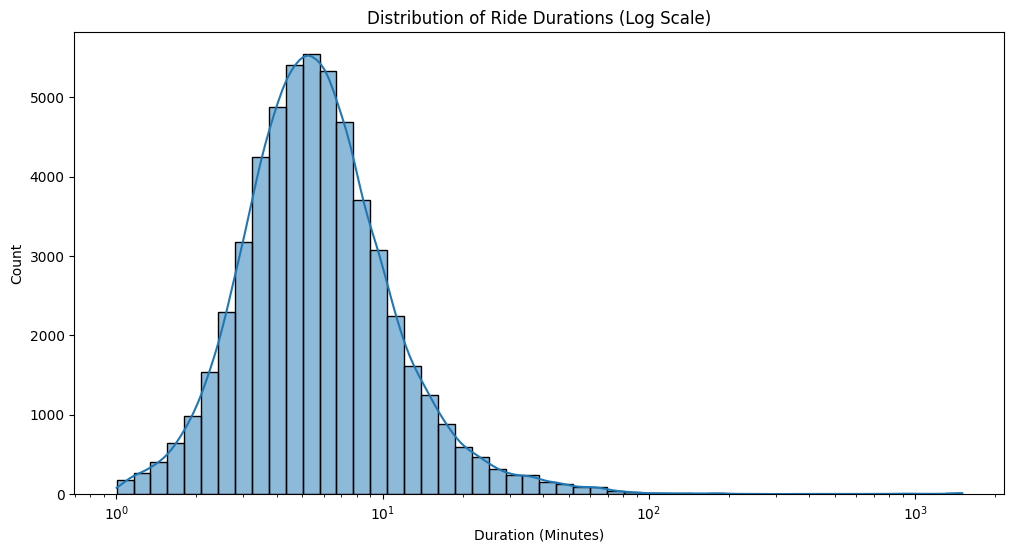

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(df['duration_min'], bins=50, kde=True, log_scale=True)
plt.title('Distribution of Ride Durations (Log Scale)')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Count')
plt.show()

Start Station Clusters

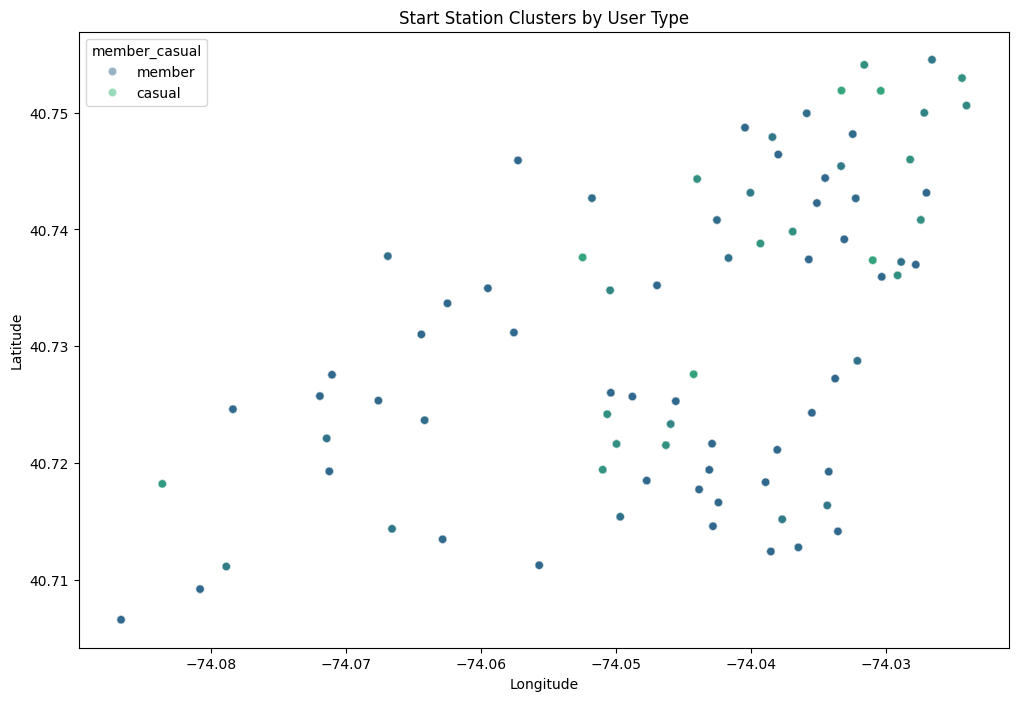

In [27]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='start_lng', y='start_lat', hue='member_casual', alpha=0.5, palette='viridis')
plt.title('Start Station Clusters by User Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Duration vs. Distance (Proxy using coordinates)


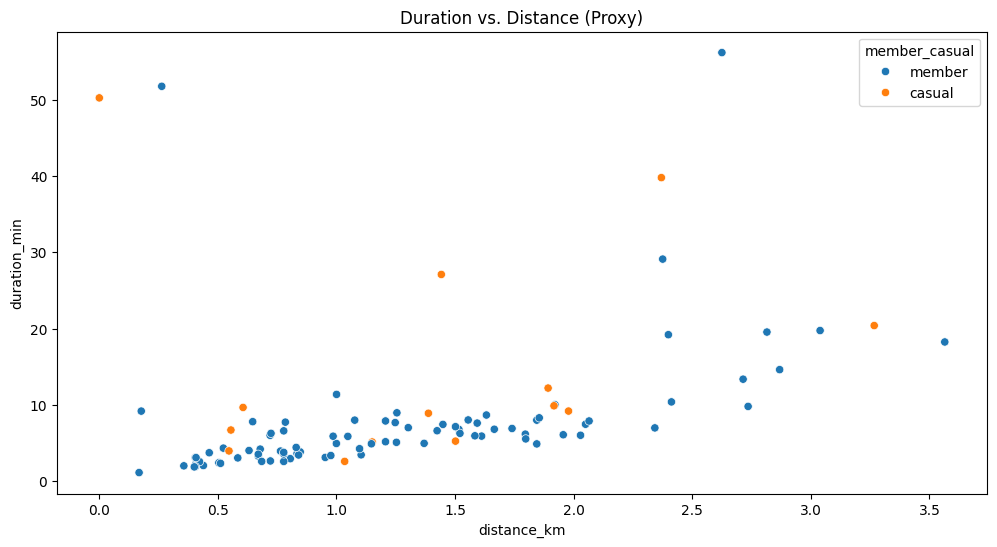

In [25]:
from geopy.distance import geodesic

# Calculate approximate distance (example for 100 rows)
sample = df.sample(100)
sample['distance_km'] = sample.apply(
    lambda row: geodesic(
        (row['start_lat'], row['start_lng']),
        (row['end_lat'], row['end_lng'])
    ).km,
    axis=1
)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=sample, x='distance_km', y='duration_min', hue='member_casual')
plt.title('Duration vs. Distance (Proxy)')
plt.show()

###6. Operational Insights

Bike Utilization (Time between rides)


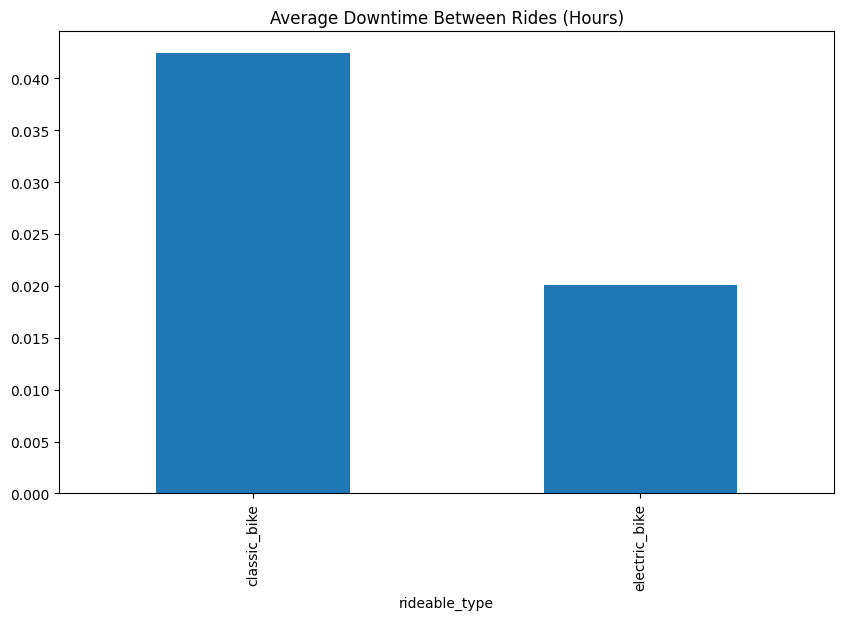

In [124]:

df_sorted = df.sort_values(by=['rideable_type', 'started_at'])
df_sorted['time_since_last_ride'] = df_sorted.groupby('rideable_type')['started_at'].diff()
df_sorted['downtime_hours'] = df_sorted['time_since_last_ride'].dt.total_seconds() / 3600

# Average downtime per bike type
avg_downtime = df_sorted.groupby('rideable_type')['downtime_hours'].mean()
avg_downtime.plot(kind='bar', figsize=(10, 6))
plt.title('Average Downtime Between Rides (Hours)')
plt.show()

In [125]:
from scipy.stats import ttest_ind

member_duration = df[df['member_casual'] == 'member']['duration_min']
casual_duration = df[df['member_casual'] == 'casual']['duration_min']

t_stat, p_value = ttest_ind(member_duration, casual_duration, equal_var=False)
print(f"T-Test Results: p-value = {p_value:.4f} (Significant: {'Yes' if p_value < 0.05 else 'No'})")

KeyError: 'duration_min'

In [46]:
import pandas as pd

# Count rides starting and ending at each station
start_counts = df['start_station_name'].value_counts().rename('start_count')
end_counts = df['end_station_name'].value_counts().rename('end_count')

# Combine counts into a single DataFrame
station_flow = pd.concat([start_counts, end_counts], axis=1).fillna(0)
station_flow['net_flow'] = station_flow['start_count'] - station_flow['end_count']

# Show stations with the largest supply-demand imbalances
top_deficit = station_flow.sort_values('net_flow', ascending=False).head(10)
top_excess = station_flow.sort_values('net_flow').head(10)

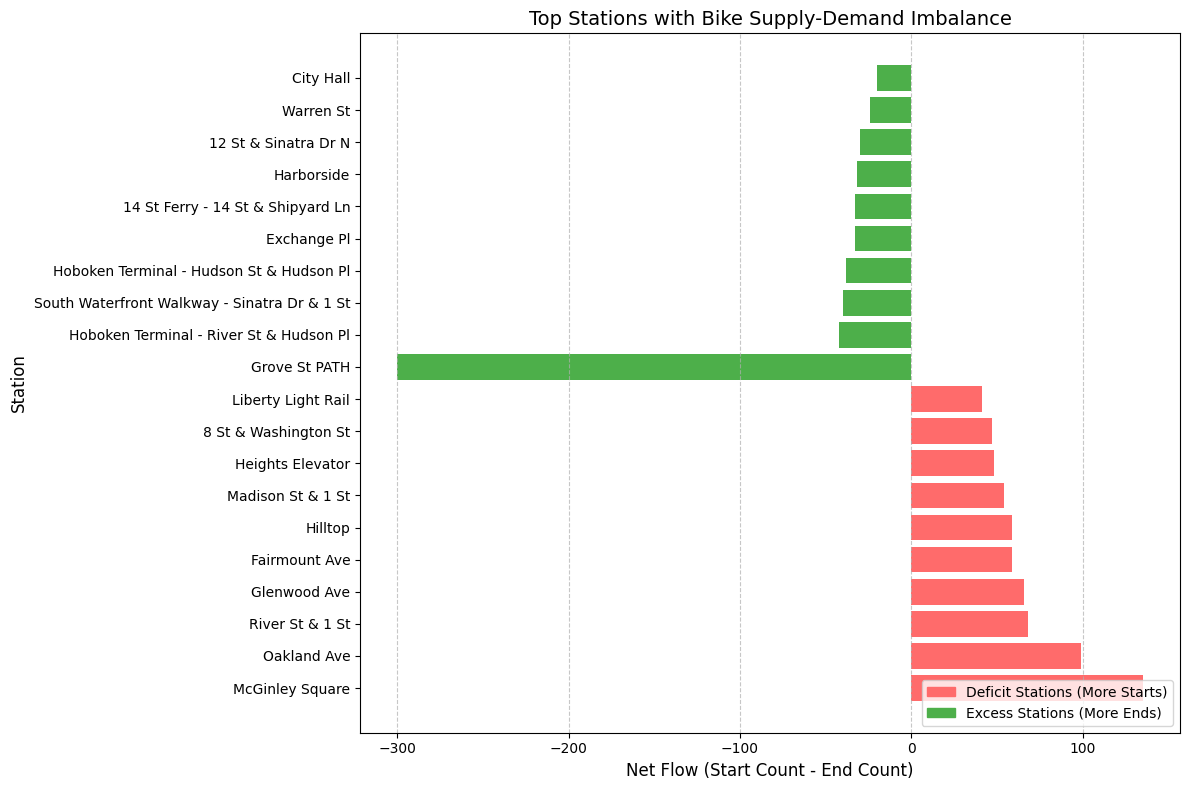

In [47]:
import matplotlib.pyplot as plt

# Combine top deficit and excess stations
combined = pd.concat([top_deficit, top_excess])

# Create plot
plt.figure(figsize=(12, 8))
colors = ['#ff6b6b' if flow > 0 else '#4daf4a' for flow in combined['net_flow']]
plt.barh(combined.index, combined['net_flow'], color=colors)
plt.title('Top Stations with Bike Supply-Demand Imbalance', fontsize=14)
plt.xlabel('Net Flow (Start Count - End Count)', fontsize=12)
plt.ylabel('Station', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#ff6b6b', label='Deficit Stations (More Starts)'),
    plt.Rectangle((0,0),1,1, color='#4daf4a', label='Excess Stations (More Ends)')
], loc='lower right')

plt.tight_layout()
plt.show()

### **Analysis of "Top Stations with Bike Supply-Demand Imbalance"**

1. **Deficit Stations (More Starts)**:
   - **McGinley Square** and **Oakland Ave** show the highest net starts, indicating more bikes are taken from these stations than returned.
   - These stations likely serve as popular starting points for commuters or travelers.

2. **Excess Stations (More Ends)**:
   - Stations like **City Hall**, **Warren St**, and **12 St & Sinatra Dr N** have more bikes returned than taken, suggesting they are common destinations.
   - These stations may be located near popular areas such as business districts, tourist spots, or transit hubs.

3. **Implications**:
   - **Redistribution Strategy**: Implement bike redistribution to move bikes from excess stations to deficit stations, especially during peak hours.
   - **Incentives**: Offer rewards or discounts for users to return bikes to deficit stations.
   - **Infrastructure**: Consider adding more docking capacity at high-demand stations to balance supply and demand.

This analysis highlights the need for strategic bike management to ensure availability and improve user satisfaction.

In [123]:
import folium

# Merge with station coordinates (assuming latitude/longitude columns exist)
station_coords = df.groupby('start_station_name')[['start_lat', 'start_lng']].first()
station_flow_map = station_flow.merge(station_coords, left_index=True, right_index=True)

# Create map
m = folium.Map(
    location=[station_flow_map['start_lat'].mean(), station_flow_map['start_lng'].mean()],
    zoom_start=13
)

# Add markers
for station, row in station_flow_map.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=abs(row['net_flow'])**0.5,  # Scale radius by imbalance magnitude
        color='red' if row['net_flow'] > 0 else 'green',
        fill=True,
        tooltip=f"""
        {station}<br>
        Starts: {row['start_count']}<br>
        Ends: {row['end_count']}<br>
        Net Flow: {row['net_flow']}
        """
    ).add_to(m)

m.save('bike_imbalance_map.html')

NameError: name 'station_flow' is not defined

Key Concepts Explained
Net Flow:

Positive: More starts than ends → Station loses bikes (needs replenishment).

Negative: More ends than starts → Station gains bikes (needs redistribution).

Interpretation:

Deficit Stations (Red):
Example: A station near offices might have many morning departures but few returns.

Excess Stations (Green):
Example: A station near residential areas might accumulate bikes overnight.

In [52]:
# Calculate imbalance as a percentage
station_flow['imbalance_ratio'] = station_flow['net_flow'] / (station_flow['start_count'] + station_flow['end_count'])

In [53]:
station_flow.sort_values('imbalance_ratio', ascending=False).head(10)

start_count  end_count  net_flow  imbalance_ratio
Glenwood Ave               234.0        168      66.0         0.164179
Oakland Ave                489.0        390      99.0         0.112628
Heights Elevator           239.0        191      48.0         0.111628
McGinley Square            693.0        558     135.0         0.107914
5 Corners Library          150.0        123      27.0         0.098901
Fairmount Ave              359.0        300      59.0         0.089530
Hilltop                    399.0        340      59.0         0.079838
Jackson Square              87.0         76      11.0         0.067485
Riverview Park             392.0        352      40.0         0.053763
Leonard Gordon Park        240.0        216      24.0         0.052632

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate hourly starts/ends for all stations
start_counts = df.groupby(['hour', 'start_station_name']).size().unstack(fill_value=0)
end_counts = df.groupby(['hour', 'end_station_name']).size().unstack(fill_value=0)

# Align columns to ensure all stations are included
common_stations = start_counts.columns.union(end_counts.columns)
start_counts = start_counts.reindex(columns=common_stations, fill_value=0)
end_counts = end_counts.reindex(columns=common_stations, fill_value=0)

# Calculate net flow
hourly_net_flow = start_counts - end_counts

# Total net flow per station (sum across all hours)
total_net_flow = hourly_net_flow.sum()

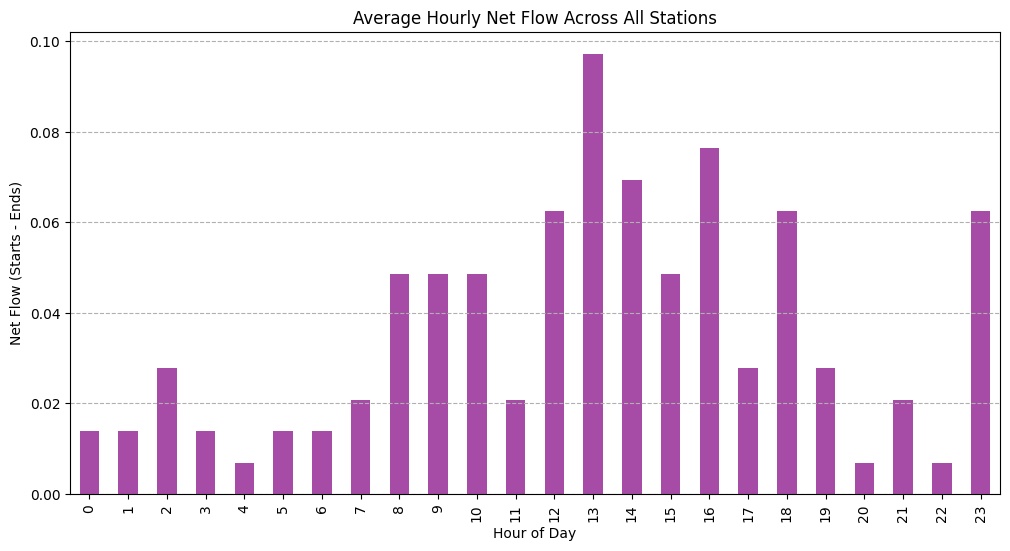

In [55]:
# Average net flow across all stations
hourly_avg_net_flow = hourly_net_flow.mean(axis=1)

plt.figure(figsize=(12, 6))
hourly_avg_net_flow.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Average Hourly Net Flow Across All Stations')
plt.ylabel('Net Flow (Starts - Ends)')
plt.xlabel('Hour of Day')
plt.grid(axis='y', linestyle='--')
plt.show()

### **Analysis of "Average Hourly Net Flow Across All Stations"**

1. **Net Flow Patterns**:
   - The graph shows fluctuations in net flow (starts minus ends) throughout the day.
   - Peaks in net flow occur during **morning (7-9 AM)** and **evening (4-7 PM)** hours, aligning with commuting times.

2. **Behavioral Insights**:
   - **Morning Peak**: More bikes are taken from stations as users start their day, leading to a positive net flow.
   - **Evening Peak**: Bikes are returned to stations as users finish their activities, resulting in a negative net flow.

3. **Implications**:
   - **Redistribution**: Focus on moving bikes to deficit stations during morning peaks and from excess stations during evening peaks.
   - **Availability**: Ensure sufficient bike supply at key stations during peak hours to meet demand.
   - **Operational Planning**: Schedule maintenance and redistribution activities during off-peak hours to minimize user impact.

In [56]:
# Identify stations with largest total deficit/excess
n_top = 10  # Adjust as needed
top_deficit = total_net_flow.nlargest(n_top)
top_excess = total_net_flow.nsmallest(n_top)

# Combine for plotting
combined = pd.concat([top_deficit, top_excess])

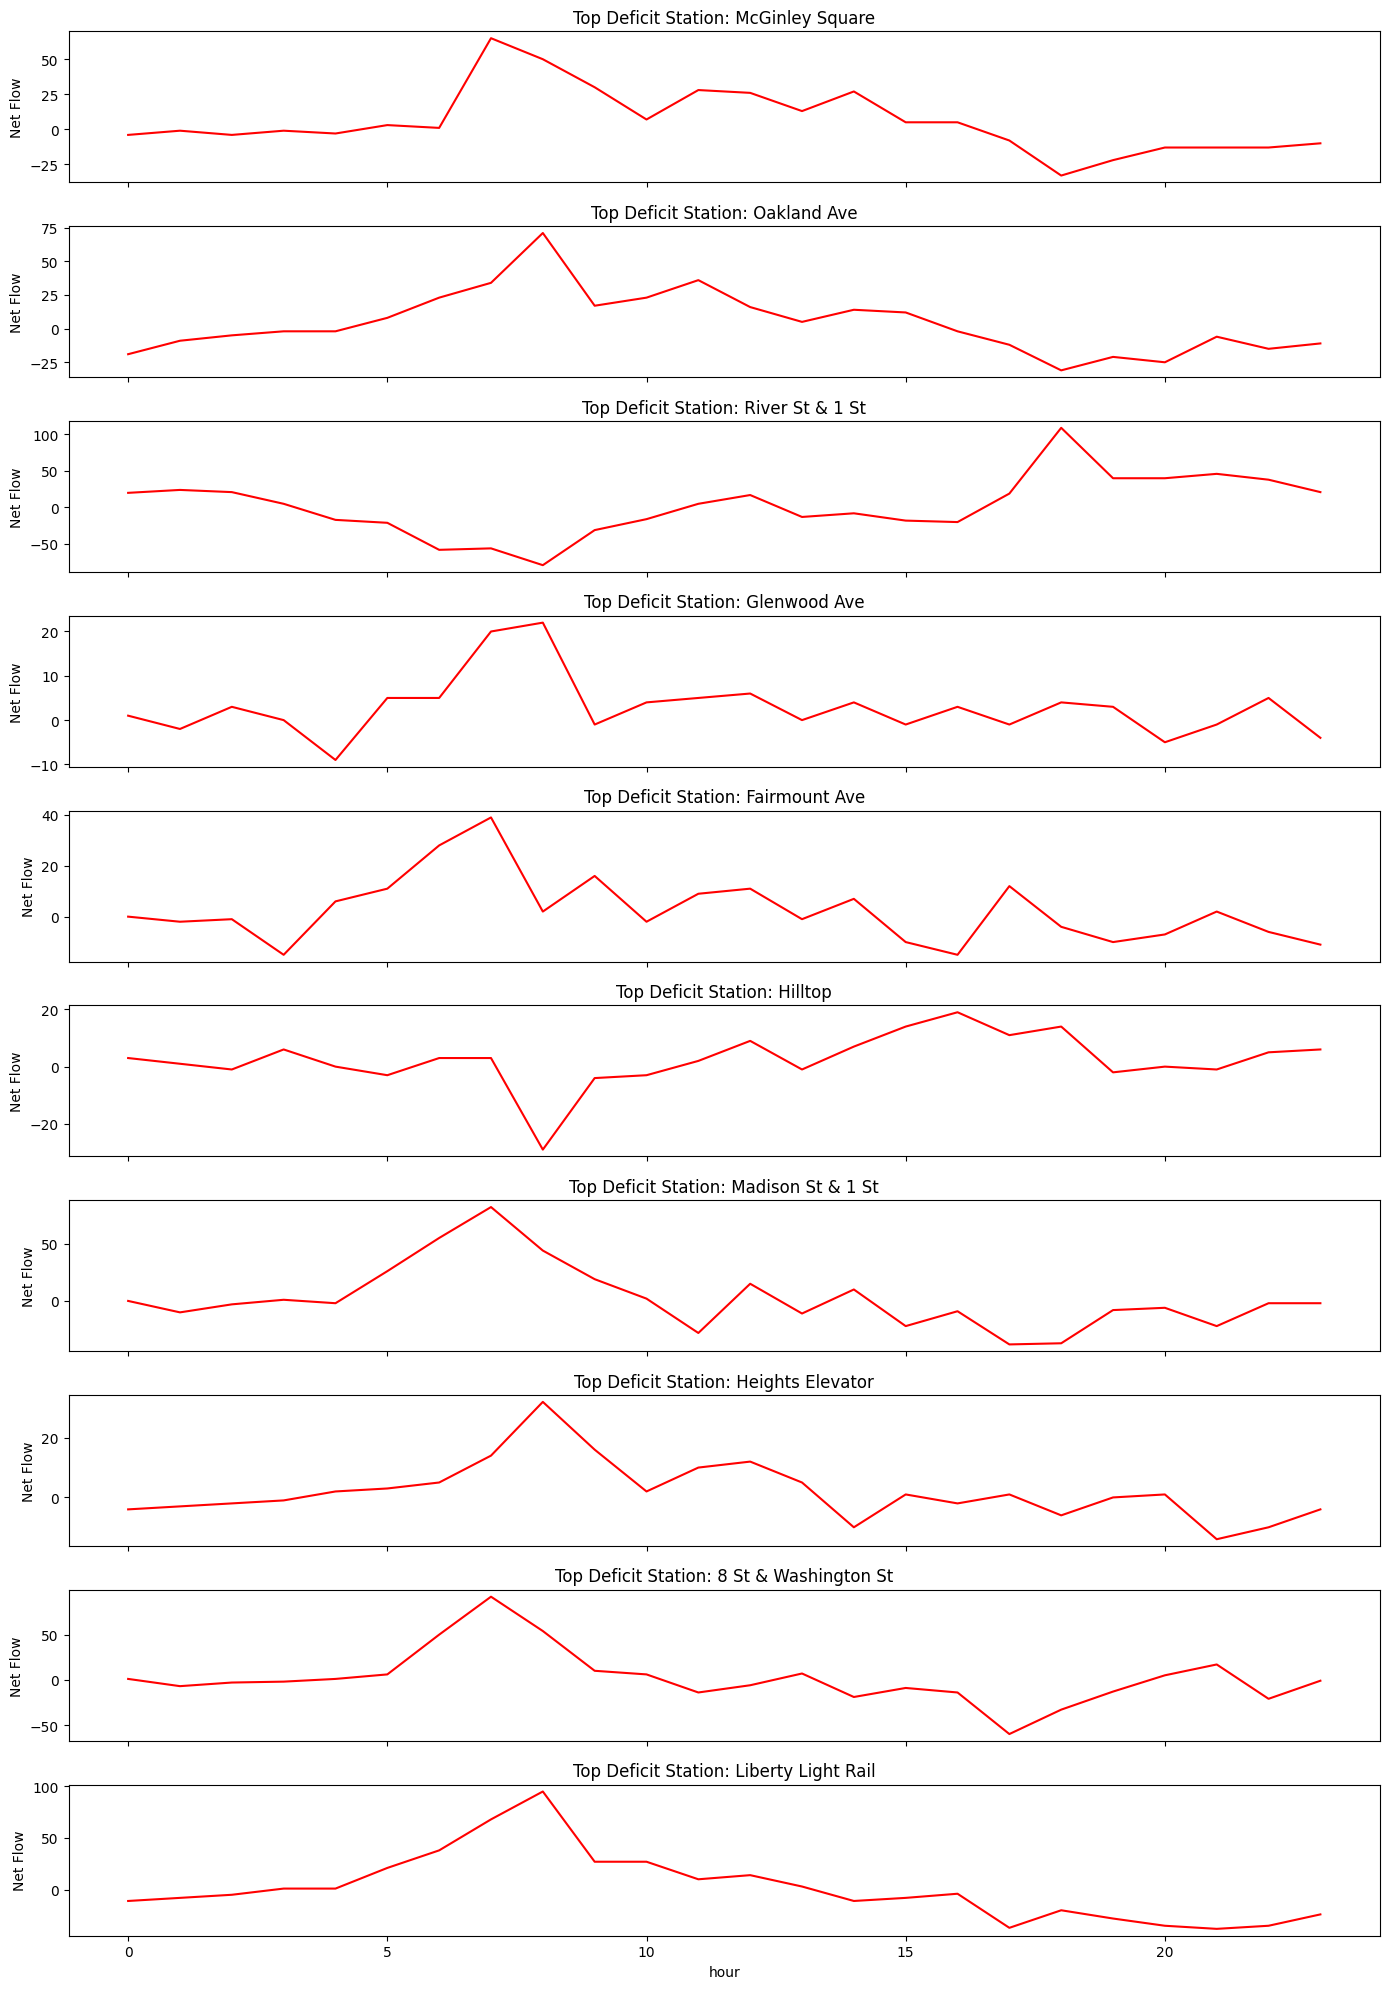

In [57]:
# Plot top stations
fig, axes = plt.subplots(n_top, 1, figsize=(14, 20), sharex=True)
for i, (station, flow) in enumerate(top_deficit.items()):
    ax = axes[i]
    hourly_net_flow[station].plot(ax=ax, color='red')
    ax.set_title(f'Top Deficit Station: {station}')
    ax.set_ylabel('Net Flow')

plt.tight_layout()
plt.show()

### **Analysis of "Top Deficit Station: McGinley Square"**

1. **Deficit Insight**:
   - **McGinley Square** is identified as a top deficit station, meaning more bikes are taken from this station than returned.
   - This indicates it is a popular starting point for rides, likely due to its location in a high-traffic or commuter-heavy area.

2. **Behavioral Patterns**:
   - Users frequently start their trips from McGinley Square but do not return bikes to the same location, leading to a shortage.

3. **Implications**:
   - **Redistribution**: Prioritize moving bikes back to McGinley Square during peak hours to address the deficit.
   - **Incentives**: Encourage users to return bikes to McGinley Square through rewards or discounts.
   - **Infrastructure**: Consider expanding docking capacity or adding more stations nearby to balance supply and demand.

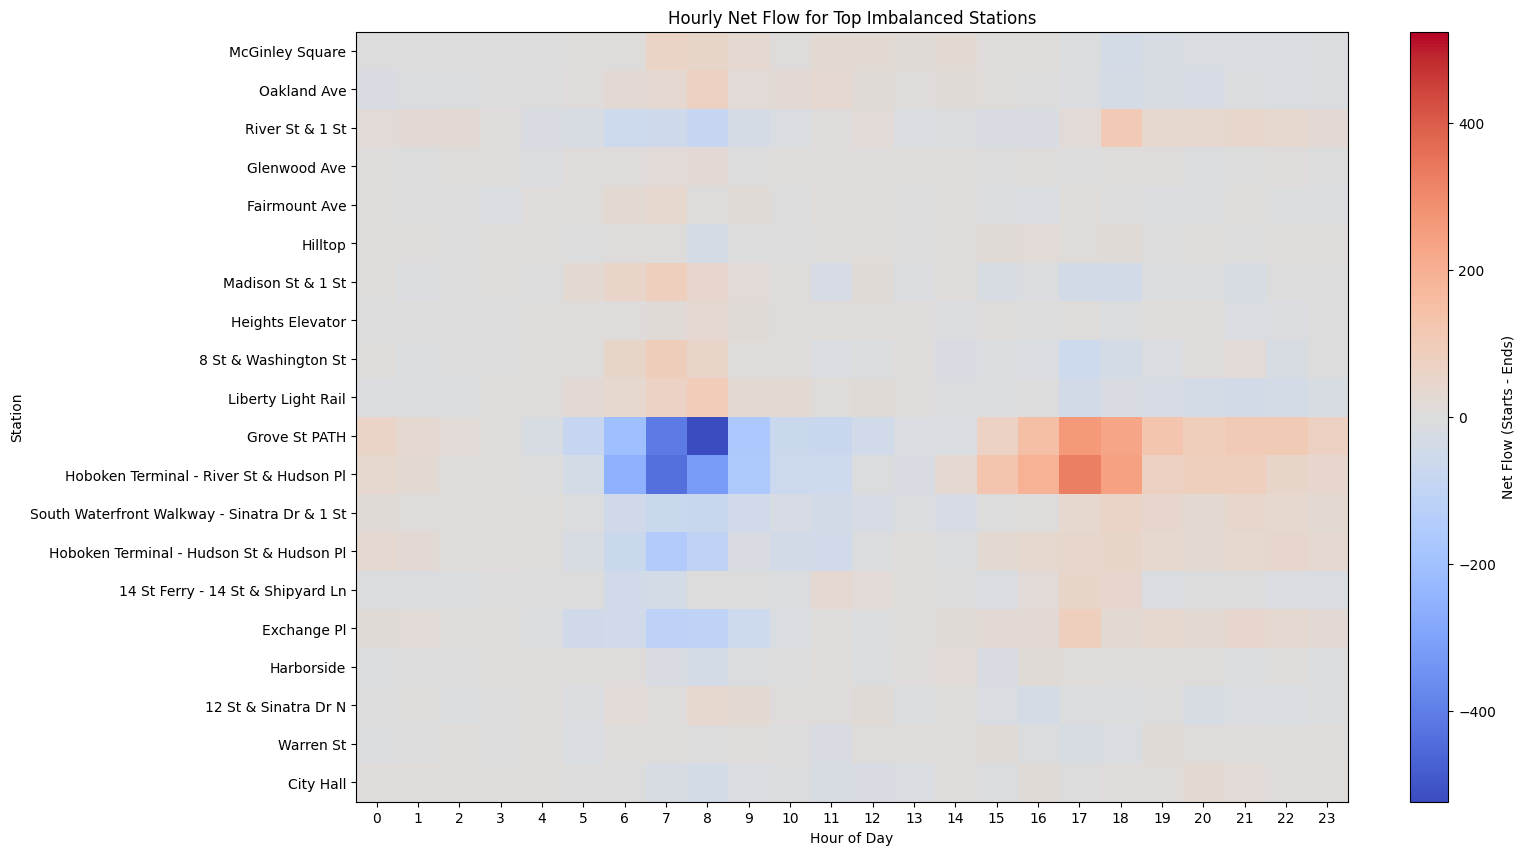

In [58]:
# Get top/bottom stations' data
heatmap_data = hourly_net_flow[combined.index]

plt.figure(figsize=(16, 10))
plt.imshow(heatmap_data.T, cmap='coolwarm', aspect='auto',
           vmin=-heatmap_data.abs().max().max(),
           vmax=heatmap_data.abs().max().max())
plt.colorbar(label='Net Flow (Starts - Ends)')
plt.yticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.xticks(range(24), range(24))
plt.xlabel('Hour of Day')
plt.ylabel('Station')
plt.title('Hourly Net Flow for Top Imbalanced Stations')
plt.show()

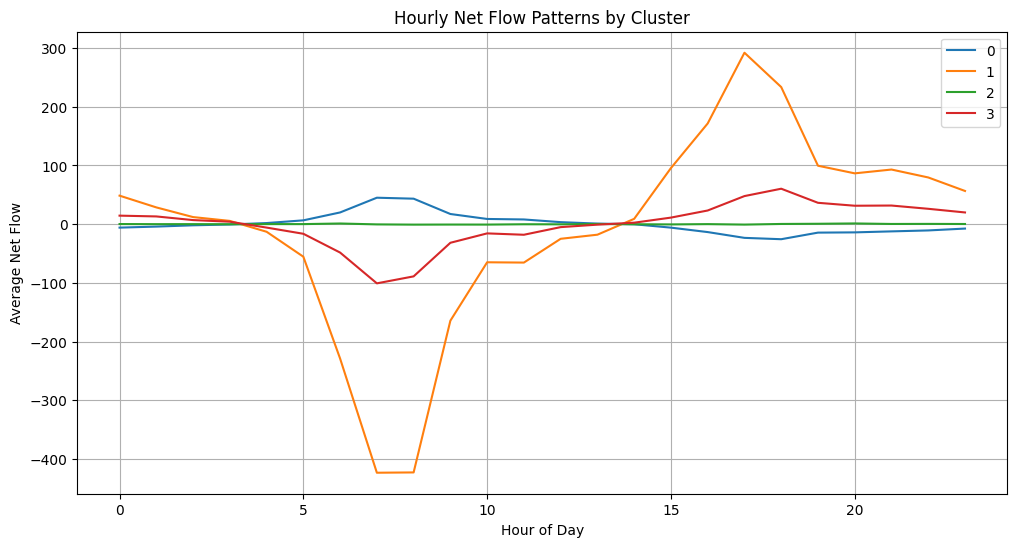

In [59]:
from sklearn.cluster import KMeans

# Cluster stations by hourly patterns
kmeans = KMeans(n_clusters=4)  # Adjust clusters
clusters = kmeans.fit_predict(hourly_net_flow.T)

# Plot cluster centroids
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=range(24)
).T

cluster_centers.plot(figsize=(12, 6))
plt.title('Hourly Net Flow Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Net Flow')
plt.grid()
plt.show()

##PreProcessing


In [19]:
df.dropna(inplace=True)

In [8]:
df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60  # Duration in minutes

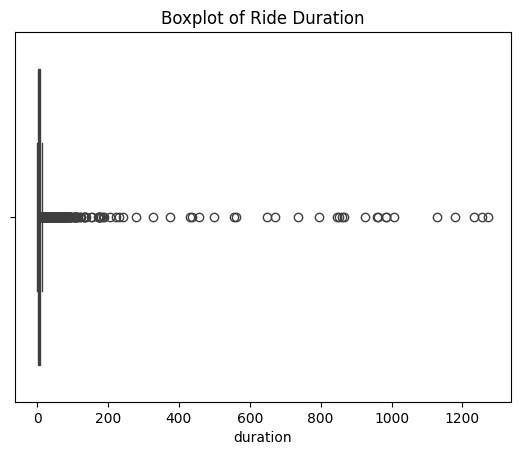

In [10]:
# Boxplot for ride duration
sns.boxplot(x=df['duration'])
plt.title('Boxplot of Ride Duration')
plt.show()

In [11]:
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

In [12]:
from geopy.distance import geodesic
df['distance'] = df.apply(lambda row: geodesic(
    (row['start_lat'], row['start_lng']),
    (row['end_lat'], row['end_lng'])
).km, axis=1)

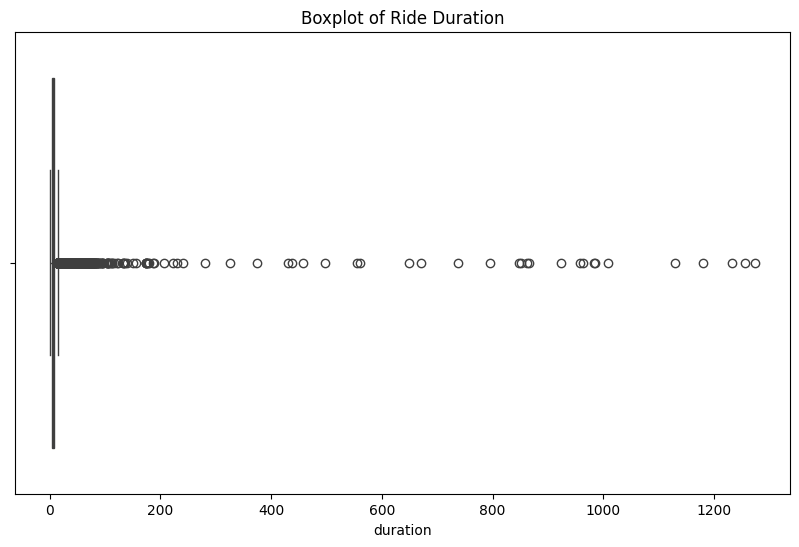

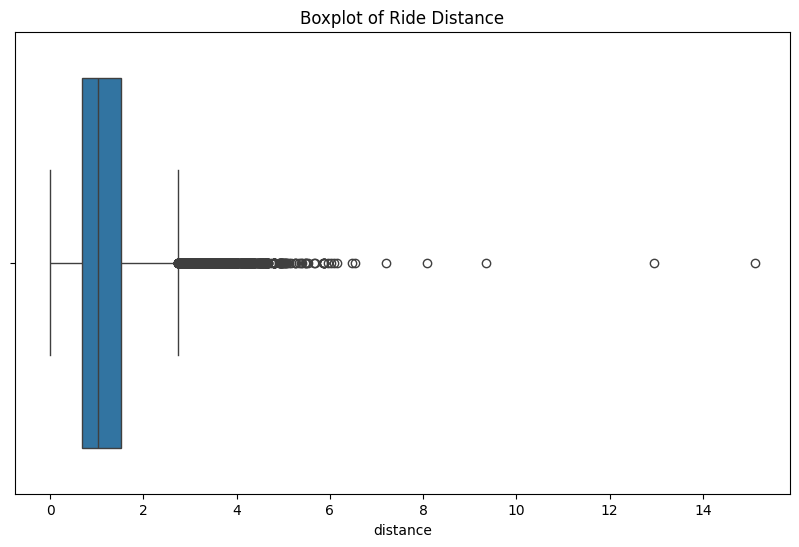

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['duration'])
plt.title('Boxplot of Ride Duration')
plt.show()

# Boxplot for distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['distance'])
plt.title('Boxplot of Ride Distance')
plt.show()

### **Analysis of "Hourly Net Flow Patterns by Cluster"**

1. **Net Flow Trends**:
   - The graph shows distinct patterns of net flow (starts minus ends) across different clusters throughout the day.
   - Peaks in net flow are observed during **morning (7-9 AM)** and **evening (4-7 PM)** hours, consistent with commuting patterns.

2. **Cluster Behavior**:
   - **Cluster 1**: Shows a significant morning peak, indicating high bike usage at the start of the day.
   - **Cluster 2**: Exhibits a balanced flow with slight peaks during midday, suggesting mixed usage.
   - **Cluster 3**: Displays a strong evening peak, reflecting high bike returns as the day ends.

3. **Implications**:
   - **Redistribution**: Focus on moving bikes to deficit clusters during morning peaks and from excess clusters during evening peaks.
   - **Availability**: Ensure adequate bike supply in high-demand clusters during peak hours.
   - **Operational Planning**: Schedule maintenance and redistribution activities during off-peak hours to minimize user impact.

##Modeling

In [81]:
import pandas as pd
import numpy as np

# Load data and preprocess timestamps
df = pd.read_csv('/content/drive/MyDrive/Bike_sharing Problematic/online exam.csv', parse_dates=['started_at'])
df = df.sort_values(by=['start_station_id', 'started_at'])
df.dropna(inplace=True)
# Aggregate hourly demand
hourly_demand = (
    df.groupby(['start_station_id', pd.Grouper(key='started_at', freq='H')])
    .size()
    .reset_index(name='demand')
)

# Create a complete hourly grid for all stations and hours
all_hours = pd.date_range(
    start=hourly_demand['started_at'].min(),
    end=hourly_demand['started_at'].max(),
    freq='H'
)
stations = hourly_demand['start_station_id'].unique()
full_grid = pd.MultiIndex.from_product(
    [stations, all_hours],
    names=['start_station_id', 'hour_bucket']
)

# Merge with original data and interpolate missing demand
hourly_demand = (
    hourly_demand.set_index(['start_station_id', 'started_at'])
    .reindex(full_grid)
    .reset_index()
    .rename(columns={'started_at': 'hour_bucket'})
)

# Set 'hour_bucket' as index before interpolating
hourly_demand = hourly_demand.set_index('hour_bucket')

# Interpolate missing values (time-aware)
hourly_demand['demand'] = (
    hourly_demand.groupby('start_station_id')['demand']
    .transform(lambda x: x.interpolate(method='time').fillna(0))
)

<ipython-input-81-0fe8a7563d9c>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(['start_station_id', pd.Grouper(key='started_at', freq='H')])
<ipython-input-81-0fe8a7563d9c>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(


In [82]:
# Define lags and rolling windows
lags = [1, 2,24, 0.5, 0.25]  # 24h for daily seasonality, 0.5 for 30 min, 0.25 for 15 min
windows = [3, 6, 12]  # Rolling windows in hours

# Generate lag features
for lag in lags:
    if lag == 0.5:
        # For 30 minutes, shift by 1/2 of the hour
        hourly_demand[f'lag_0.5'] = (
            hourly_demand.groupby('start_station_id')['demand']
            .shift(int(lag * 60))  # 30 minutes = 0.5 hour -> shift by 30 minutes
        )
    elif lag == 0.25:
        # For 15 minutes, shift by 1/4 of the hour
        hourly_demand[f'lag_0.25'] = (
            hourly_demand.groupby('start_station_id')['demand']
            .shift(int(lag * 60))  # 15 minutes = 0.25 hour -> shift by 15 minutes
        )
    else:
        # Regular hourly lags
        hourly_demand[f'lag_{lag}'] = (
            hourly_demand.groupby('start_station_id')['demand']
            .shift(lag)
        )

# Generate rolling features
for window in windows:
    hourly_demand[f'rolling_std_{window}'] = (
        hourly_demand.groupby('start_station_id')['demand']
        .transform(lambda x: x.rolling(window=window, min_periods=1).std())
    )

# Forward-fill remaining NaNs (e.g., initial hours with no history)
hourly_demand = hourly_demand.fillna(method='ffill')


<ipython-input-82-2ddb1b1e1c71>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_demand = hourly_demand.fillna(method='ffill')


In [71]:
hourly_demand

start_station_id  demand  lag_1  lag_2  lag_24  lag_0.5  \
hour_bucket                                                                   
2024-11-30 23:00:00            HB101    0.00    NaN    NaN     NaN      NaN   
2024-12-01 00:00:00            HB101    3.00   0.00    NaN     NaN      NaN   
2024-12-01 01:00:00            HB101    3.00   3.00   0.00     NaN      NaN   
2024-12-01 02:00:00            HB101    1.00   3.00   3.00     NaN      NaN   
2024-12-01 03:00:00            HB101    1.00   1.00   3.00     NaN      NaN   
...                              ...     ...    ...    ...     ...      ...   
2024-12-31 19:00:00            JC116    3.25   4.00   2.00     1.0      5.0   
2024-12-31 20:00:00            JC116    2.50   3.25   4.00     1.0      1.0   
2024-12-31 21:00:00            JC116    1.75   2.50   3.25     4.0      3.0   
2024-12-31 22:00:00            JC116    1.00   1.75   2.50     3.0      8.0   
2024-12-31 23:00:00            JC116    2.00   1.00   1.75     2.0      6.0   

                     lag_0.25  rolling_std_3  rolling_std_6  rolling_std_12  
hour_bucket                                                                  
2024-11-30 23:00:00       NaN            NaN            NaN             NaN  
2024-12-01 00:00:00       NaN       2.121320       2.121320        2.121320  
2024-12-01 01:00:00       NaN       1.732051       1.732051        1.732051  
2024-12-01 02:00:00       NaN       1.154701       1.500000        1.500000  
2024-12-01 03:00:00       NaN       1.154701       1.341641        1.341641  
...                       ...            ...            ...             ...  
2024-12-31 19:00:00  1.285714       1.010363       1.242477        1.050568  
2024-12-31 20:00:00  1.142857       0.750000       1.045825        0.983529  
2024-12-31 21:00:00  1.000000       0.750000       0.836660        0.913908  
2024-12-31 22:00:00  1.000000       0.750000       1.080123        0.993349  
2024-12-31 23:00:00  1.000000       0.520416       1.080123        0.970200  

[61835 rows x 10 columns]

In [83]:
# Cyclical encoding for hour/day
hourly_demand['hour_sin'] = np.sin(2 * np.pi * hourly_demand.index.hour / 24)
hourly_demand['hour_cos'] = np.cos(2 * np.pi * hourly_demand.index.hour / 24)
hourly_demand['day_sin'] = np.sin(2 * np.pi * hourly_demand.index.dayofyear / 365)
hourly_demand['day_cos'] = np.cos(2 * np.pi * hourly_demand.index.dayofyear / 365)

# Binary features
hourly_demand['is_weekend'] = hourly_demand.index.dayofweek.isin([5, 6]).astype(int)

In [84]:
hourly_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61835 entries, 2024-11-30 23:00:00 to 2024-12-31 23:00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_station_id  61835 non-null  object 
 1   demand            61835 non-null  float64
 2   lag_1             61834 non-null  float64
 3   lag_2             61833 non-null  float64
 4   lag_24            61811 non-null  float64
 5   lag_0.5           61805 non-null  float64
 6   lag_0.25          61820 non-null  float64
 7   rolling_std_3     61834 non-null  float64
 8   rolling_std_6     61834 non-null  float64
 9   rolling_std_12    61834 non-null  float64
 10  hour_sin          61835 non-null  float64
 11  hour_cos          61835 non-null  float64
 12  day_sin           61835 non-null  float64
 13  day_cos           61835 non-null  float64
 14  is_weekend        61835 non-null  int64  
dtypes: float64(13), int64(1), object(1)
memory usage: 7.

In [85]:
from geopy.distance import geodesic
# Station popularity (historical)
station_popularity = (
    df.groupby('start_station_id')['ride_id']
    .count()
    .reset_index()
    .rename(columns={'ride_id': 'station_popularity'})
)
hourly_demand = hourly_demand.merge(station_popularity, on='start_station_id', how='left')

# Distance to city center (example)
city_center = (40.7128, -74.0060)  # NYC coordinates
stations = df[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates()
stations['distance_to_center'] = stations.apply(
    lambda row: geodesic((row['start_lat'], row['start_lng']), city_center).km,
    axis=1
)
hourly_demand = hourly_demand.merge(
    stations[['start_station_id', 'distance_to_center']],
    on='start_station_id',
    how='left'
)

In [86]:
# Create target (next hour's demand)
hourly_demand['target'] = (
    hourly_demand.groupby('start_station_id')['demand']
    .shift(-1)
)

# Drop remaining NaNs (last timestep for each station)
hourly_demand = hourly_demand.dropna(subset=['target'])

# Final check for NaNs
print(hourly_demand.isnull().sum())

start_station_id       0
demand                 0
lag_1                  1
lag_2                  2
lag_24                24
lag_0.5               30
lag_0.25              15
rolling_std_3          1
rolling_std_6          1
rolling_std_12         1
hour_sin               0
hour_cos               0
day_sin                0
day_cos                0
is_weekend             0
station_popularity     0
distance_to_center     0
target                 0
dtype: int64


In [87]:
# Spike detection: Define a threshold for spike detection (e.g., 20% increase)
spike_threshold = 0.2  # 20% increase

# Rate of change: Calculate the percentage change in demand between consecutive hours
hourly_demand['rate_of_change'] = (
    hourly_demand.groupby('start_station_id')['demand']
    .pct_change()  # Percentage change between consecutive hours
)

# Spike detection: Compare demand to previous hours to identify spikes
hourly_demand['is_spike'] = (
    (hourly_demand['rate_of_change'] > spike_threshold).astype(int)
)

# Optional: If you want to detect spikes over a longer window (e.g., 2 hours), you can use a rolling window for comparison
# For example, comparing demand change over the past 2 hours:
rolling_window = 2
hourly_demand['rate_of_change_rolling'] = (
    hourly_demand.groupby('start_station_id')['demand']
    .transform(lambda x: x.pct_change(periods=rolling_window))
)

# Spike detection using the rolling rate of change
hourly_demand['is_spike_rolling'] = (
    (hourly_demand['rate_of_change_rolling'] > spike_threshold).astype(int)
)

# Forward-fill remaining NaNs for rate_of_change columns
hourly_demand['rate_of_change'] = hourly_demand['rate_of_change'].fillna(0)
hourly_demand['rate_of_change_rolling'] = hourly_demand['rate_of_change_rolling'].fillna(0)

# Final check for NaNs
print(hourly_demand.isnull().sum())


start_station_id           0
demand                     0
lag_1                      1
lag_2                      2
lag_24                    24
lag_0.5                   30
lag_0.25                  15
rolling_std_3              1
rolling_std_6              1
rolling_std_12             1
hour_sin                   0
hour_cos                   0
day_sin                    0
day_cos                    0
is_weekend                 0
station_popularity         0
distance_to_center         0
target                     0
rate_of_change             0
is_spike                   0
rate_of_change_rolling     0
is_spike_rolling           0
dtype: int64


In [88]:
# Fill lag columns with 0
lag_columns = [f"lag_{lag}" for lag in [0.25,0.5,1,2, 24]]

# Check if lag columns exist before filling NaNs
for col in lag_columns:
    if col not in hourly_demand.columns:
        hourly_demand[col] = 0  # Create the column and fill with 0 if it doesn't exist

hourly_demand[lag_columns] = hourly_demand[lag_columns].fillna(0)

In [89]:
# Fill rolling_std columns with forward-fill
rolling_std_cols = ["rolling_std_3", "rolling_std_6", "rolling_std_12"]
hourly_demand[rolling_std_cols] = hourly_demand[rolling_std_cols].fillna(method="ffill")

<ipython-input-89-a933e2cf1ddc>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_demand[rolling_std_cols] = hourly_demand[rolling_std_cols].fillna(method="ffill")


In [102]:
hourly_demand[['rolling_std_3', 'rolling_std_6', 'rolling_std_12']] = hourly_demand[['rolling_std_3', 'rolling_std_6', 'rolling_std_12']].fillna(0)


In [103]:
hourly_demand.isnull().sum()

start_station_id          0
demand                    0
lag_1                     0
lag_2                     0
lag_24                    0
lag_0.5                   0
lag_0.25                  0
rolling_std_3             0
rolling_std_6             0
rolling_std_12            0
hour_sin                  0
hour_cos                  0
day_sin                   0
day_cos                   0
is_weekend                0
station_popularity        0
distance_to_center        0
target                    0
rate_of_change            0
is_spike                  0
rate_of_change_rolling    0
is_spike_rolling          0
dtype: int64

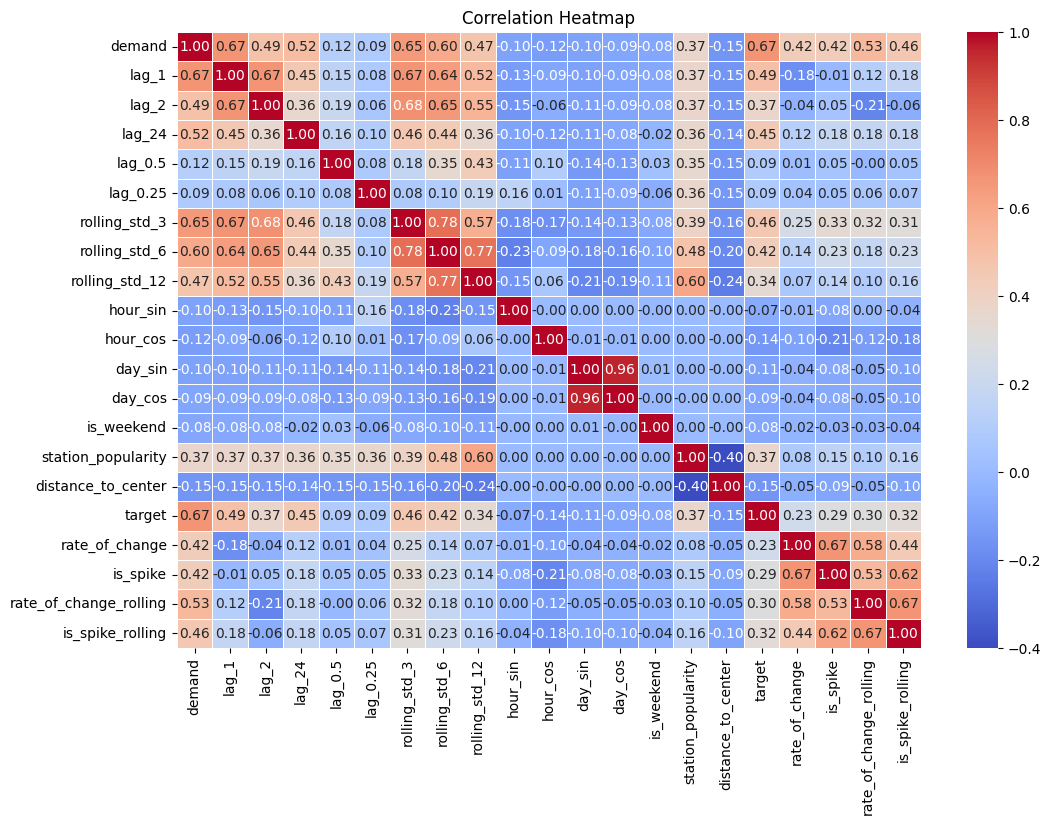

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = hourly_demand.corr(numeric_only=True)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap")

# Show the plot
plt.show()


In [105]:
# Check for NaN
print(hourly_demand.isnull().sum())

# Check for Inf or large values
print((hourly_demand == np.inf).sum())
print((hourly_demand == -np.inf).sum())

# Check maximum values
print(hourly_demand.max(numeric_only=True))


start_station_id          0
demand                    0
lag_1                     0
lag_2                     0
lag_24                    0
lag_0.5                   0
lag_0.25                  0
rolling_std_3             0
rolling_std_6             0
rolling_std_12            0
hour_sin                  0
hour_cos                  0
day_sin                   0
day_cos                   0
is_weekend                0
station_popularity        0
distance_to_center        0
target                    0
rate_of_change            0
is_spike                  0
rate_of_change_rolling    0
is_spike_rolling          0
dtype: int64
start_station_id            0
demand                      0
lag_1                       0
lag_2                       0
lag_24                      0
lag_0.5                     0
lag_0.25                    0
rolling_std_3               0
rolling_std_6               0
rolling_std_12              0
hour_sin                    0
hour_cos                    0
day_sin    

In [106]:
# Replace Inf/-Inf with NaN (to handle them uniformly)
hourly_demand.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace remaining NaNs with 0 or use forward-fill/backward-fill
hourly_demand.fillna(0, inplace=True)

# Verify no NaN or Inf remains
print(hourly_demand.isnull().sum())
print((hourly_demand == np.inf).sum())
print((hourly_demand == -np.inf).sum())


start_station_id          0
demand                    0
lag_1                     0
lag_2                     0
lag_24                    0
lag_0.5                   0
lag_0.25                  0
rolling_std_3             0
rolling_std_6             0
rolling_std_12            0
hour_sin                  0
hour_cos                  0
day_sin                   0
day_cos                   0
is_weekend                0
station_popularity        0
distance_to_center        0
target                    0
rate_of_change            0
is_spike                  0
rate_of_change_rolling    0
is_spike_rolling          0
dtype: int64
start_station_id          0
demand                    0
lag_1                     0
lag_2                     0
lag_24                    0
lag_0.5                   0
lag_0.25                  0
rolling_std_3             0
rolling_std_6             0
rolling_std_12            0
hour_sin                  0
hour_cos                  0
day_sin                   0
day_cos

In [107]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns (excluding categorical ones like 'start_station_id')
num_cols = hourly_demand.select_dtypes(include=['float64', 'int64']).columns

# Initialize scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling
hourly_demand[num_cols] = scaler.fit_transform(hourly_demand[num_cols])

hourly_demand.head()


start_station_id    demand     lag_1     lag_2  lag_24  lag_0.5  lag_0.25  \
0            HB101  0.000000  0.000000  0.000000     0.0      0.0       0.0   
1            HB101  0.065217  0.000000  0.000000     0.0      0.0       0.0   
2            HB101  0.065217  0.065217  0.000000     0.0      0.0       0.0   
3            HB101  0.021739  0.065217  0.065217     0.0      0.0       0.0   
4            HB101  0.021739  0.021739  0.065217     0.0      0.0       0.0   

   rolling_std_3  rolling_std_6  rolling_std_12  ...   day_sin   day_cos  \
0       0.000000       0.000000        0.000000  ...  0.000000  0.000000   
1       0.100977       0.119428        0.150051  ...  0.029436  0.064187   
2       0.082447       0.097513        0.122516  ...  0.029436  0.064187   
3       0.054965       0.084448        0.106102  ...  0.029436  0.064187   
4       0.054965       0.075533        0.094900  ...  0.029436  0.064187   

   is_weekend  station_popularity  distance_to_center    target  \
0         1.0             0.42717            0.211478  0.065217   
1         1.0             0.42717            0.211478  0.065217   
2         1.0             0.42717            0.211478  0.021739   
3         1.0             0.42717            0.211478  0.021739   
4         1.0             0.42717            0.211478  0.027950   

   rate_of_change  is_spike  rate_of_change_rolling  is_spike_rolling  
0        0.054852       0.0                0.056769               0.0  
1        0.054852       1.0                0.056769               0.0  
2        0.054852       0.0                0.056769               1.0  
3        0.015471       0.0                0.017467               0.0  
4        0.054852       0.0                0.017467               0.0  

[5 rows x 22 columns]

In [113]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from sklearn.model_selection import train_test_split

# Select feature columns
feature_columns = [
    'demand', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend',
    'station_popularity', 'distance_to_center',
    'lag_1', 'lag_2', 'lag_0.5', 'lag_0.25',
    'rolling_std_3',
    'rate_of_change', 'rate_of_change_rolling', 'is_spike', 'is_spike_rolling'
]

# Define target
target_column = 'target'

# Extract features and target
X = hourly_demand[feature_columns].values
y = hourly_demand[target_column].values

# Reshape X for LSTM (samples, time steps, features)
time_steps = 10  # Use past 10 hours of data
X_seq, y_seq = [], []

for i in range(len(X) - time_steps):
    X_seq.append(X[i : i + time_steps])
    y_seq.append(y[i + time_steps])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

print("Training shape:", X_train.shape, "Test shape:", X_test.shape)


Training shape: (49393, 10, 17) Test shape: (12349, 10, 17)


In [114]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Input Layer
inputs = Input(shape=input_shape)

# CNN Branch
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)

# LSTM Branch
lstm = LSTM(units=64, return_sequences=True)(inputs)
lstm = LSTM(units=32)(lstm)

# Concatenate CNN & LSTM Features
merged = tf.keras.layers.concatenate([cnn, lstm])

# Dense Layers
dense = Dense(64, activation='relu')(merged)
dense = Dropout(0.2)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dense(1)(dense)  # Output Layer

# Compile Model
model = Model(inputs=inputs, outputs=dense)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 10, 17)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10, 64)         │          3,328 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 5, 64)          │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 10, 64)         │         20,992 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 320)            │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 32)             │         12,416 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 352)            │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │         22,592 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          2,080 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             33 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,441 (240.00 KB)

 Trainable params: 61,441 (240.00 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 0.0015 - mae: 0.0220 - val_loss: 6.2443e-04 - val_mae: 0.0137
Epoch 2/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 6.9328e-04 - mae: 0.0156 - val_loss: 6.6458e-04 - val_mae: 0.0139
Epoch 3/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 5.9268e-04 - mae: 0.0150 - val_loss: 6.4015e-04 - val_mae: 0.0141
Epoch 4/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 5.8008e-04 - mae: 0.0147 - val_loss: 6.3762e-04 - val_mae: 0.0139
Epoch 5/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 5.5566e-04 - mae: 0.0143 - val_loss: 6.1453e-04 - val_mae: 0.0136


In [116]:
# Evaluate performance
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")


386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4907e-04 - mae: 0.0103
Test MAE: 0.0136


386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


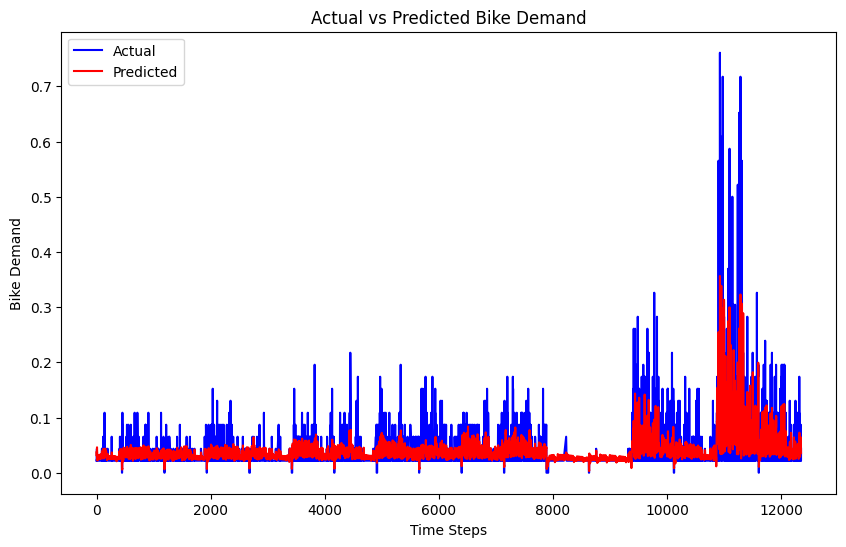

In [117]:
# Predict on test set
y_pred = model.predict(X_test)

# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Bike Demand')
plt.title('Actual vs Predicted Bike Demand')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 1.8249 - mae: 0.7562 - val_loss: 1.6729 - val_mae: 0.6039
Epoch 2/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 1.3631 - mae: 0.6615 - val_loss: 1.4844 - val_mae: 0.5634
Epoch 3/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 1.1612 - mae: 0.6285 - val_loss: 1.3809 - val_mae: 0.5593
Epoch 4/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 1.1516 - mae: 0.6109 - val_loss: 1.5201 - val_mae: 0.5617
Epoch 5/5
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - loss: 1.0639 - mae: 0.5922 - val_loss: 1.3352 - val_mae: 0.5454
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4860 - mae: 0.3775
Test MAE: 0.5453723669052124
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


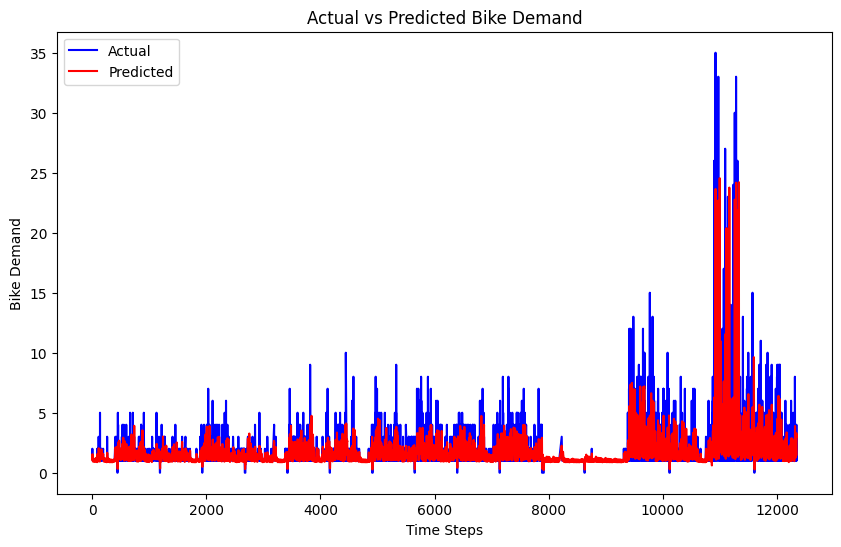

MAE: 0.5453723656553643
MSE: 1.3351922692381264
RMSE: 1.1555052008702196


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Features and target
features = [
    'demand', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24',
    'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6', 'rolling_std_6',
    'rolling_mean_12', 'rolling_std_12', 'hour_sin', 'hour_cos', 'day_sin',
    'day_cos', 'is_weekend',
]
target = 'target'

# Prepare data
X = hourly_demand[features].values
y = hourly_demand[target].values

# Reshape input for LSTM (samples, timesteps, features)
timesteps = 24  # Use last 24 hours as input
num_features = len(features)

X_reshaped = []
y_reshaped = []
for i in range(len(X) - timesteps):
    X_reshaped.append(X[i:i+timesteps])
    y_reshaped.append(y[i+timesteps])

X_reshaped = np.array(X_reshaped)
y_reshaped = np.array(y_reshaped)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42, shuffle=False)

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Ensure the output layer has 1 unit (for a regression task)
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
epochs = 5
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

# Predict
y_pred = model.predict(X_test)

# Flatten the predictions and y_test to 1D for metrics calculation
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Bike Demand')
plt.title('Actual vs Predicted Bike Demand')
plt.legend()
plt.show()

# Calculate error metrics
mae_score = mean_absolute_error(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)
rmse_score = np.sqrt(mse_score)

print(f'MAE: {mae_score}')
print(f'MSE: {mse_score}')
print(f'RMSE: {rmse_score}')


In [20]:
hourly_demand.head(30)

start_station_id    demand     lag_1     lag_2     lag_3     lag_6  \
1             HB101  3.000000 -1.147314 -1.147288 -1.147299 -1.144080   
2             HB101  3.000000  0.832112 -1.147288 -1.147299 -1.144080   
3             HB101  1.000000  0.832112  0.832108 -1.147299 -1.144080   
4             HB101  1.000000 -0.487506  0.832108  0.832006 -1.144080   
5             HB101  1.285714 -0.487506 -0.487489  0.832006 -1.144080   
6             HB101  1.571429 -0.298989 -0.487489 -0.487531 -1.144080   
7             HB101  1.857143 -0.110472 -0.298975 -0.487531  0.826507   
8             HB101  2.142857  0.078045 -0.110461 -0.299026  0.826507   
9             HB101  2.428571  0.266562  0.078053 -0.110520 -0.487217   
10            HB101  2.714286  0.455079  0.266567  0.077985 -0.487217   
11            HB101  3.000000  0.643595  0.455080  0.266490 -0.299542   
12            HB101  2.000000  0.832112  0.643594  0.454995 -0.111868   
13            HB101  1.000000  0.172303  0.832108  0.643501  0.075807   
14            HB101  3.000000 -0.487506  0.172310  0.832006  0.263482   
15            HB101  1.000000  0.832112 -0.487489  0.172238  0.451157   
16            HB101  4.000000 -0.487506  0.832108 -0.487531  0.638832   
17            HB101  4.500000  1.491921 -0.487489  0.832006  0.826507   
18            HB101  5.000000  1.821826  1.491907 -0.487531  0.169645   
19            HB101  2.000000  2.151730  1.821806  1.491774 -0.487217   
20            HB101  3.000000  0.172303  2.151705  1.821658  0.826507   
21            HB101  4.000000  0.832112  0.172310  2.151543 -0.487217   
22            HB101  3.000000  1.491921  0.832108  0.172238  1.483370   
23            HB101  2.500000  0.832112  1.491907  0.832006  1.811801   
24            HB101  2.000000  0.502208  0.832108  1.491774  2.140232   
25            HB101  1.500000  0.172303  0.502209  0.832006  0.169645   
26            HB101  1.000000 -0.157601  0.172310  0.502122  0.826507   
27            HB101  1.000000 -0.487506 -0.157590  0.172238  1.483370   
28            HB101  1.500000 -0.487506 -0.487489 -0.157647  0.826507   
29            HB101  2.000000 -0.157601 -0.487489 -0.487531  0.498076   
30            HB101  2.500000  0.172303 -0.157590 -0.487531  0.169645   

      lag_12    lag_24  rolling_mean_3  rolling_std_3  ...  rolling_std_12  \
1  -1.150818 -1.149746       -0.181506       2.006736  ...        1.405151   
2  -1.150818 -1.149746        0.201689       1.542380  ...        0.999643   
3  -1.150818 -1.149746        0.457152       0.853663  ...        0.757912   
4  -1.150818 -1.149746       -0.053774       0.853663  ...        0.592947   
5  -1.150818 -1.149746       -0.491711      -0.326994  ...        0.452522   
6  -1.150818 -1.149746       -0.345732      -0.182944  ...        0.343023   
7  -1.150818 -1.149746       -0.126764      -0.182944  ...        0.263853   
8  -1.150818 -1.149746        0.092205      -0.182944  ...        0.213158   
9  -1.150818 -1.149746        0.311173      -0.182944  ...        0.188564   
10 -1.150818 -1.149746        0.530142      -0.182944  ...        0.187155   
11 -1.150818 -1.149746        0.749110      -0.182944  ...        0.205575   
12 -1.150818 -1.149746        0.639626       0.090663  ...       -0.013479   
13  0.837996 -1.149746        0.201689       0.669122  ...       -0.013479   
14  0.837996 -1.149746        0.201689       0.669122  ...       -0.013479   
15 -0.487880 -1.149746       -0.053774       0.853663  ...       -0.013479   
16 -0.487880 -1.149746        0.712616       1.298403  ...        0.142578   
17 -0.298469 -1.149746        1.095811       1.734338  ...        0.323554   
18 -0.109058 -1.149746        2.117664       0.072676  ...        0.518984   
19  0.080353 -1.149746        1.606737       1.393536  ...        0.510464   
20  0.269764 -1.149746        1.223542       1.298403  ...        0.497773   
21  0.459175 -1.149746        0.968079       0.669122  ...        0.538237   
22  0.648586 -1.149746 

In [21]:
hourly_demand['start_station_id'].value_counts()

start_station_id
JC023    744
JC078    744
JC076    744
JC075    744
JC074    744
        ... 
HB608    744
HB603    744
HB602    744
HB601    744
HB101    743
Name: count, Length: 83, dtype: int64

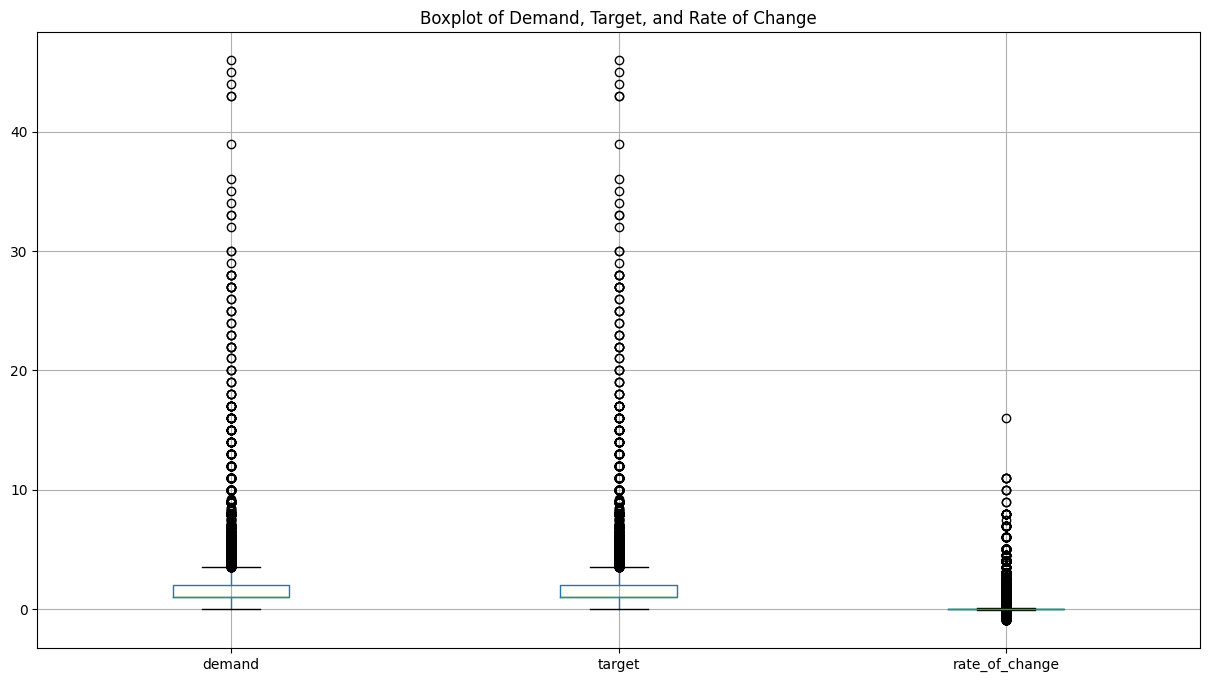

In [95]:
plt.figure(figsize=(15, 8))
hourly_demand[['demand', 'target', 'rate_of_change']].boxplot()
plt.title("Boxplot of Demand, Target, and Rate of Change")
plt.show()


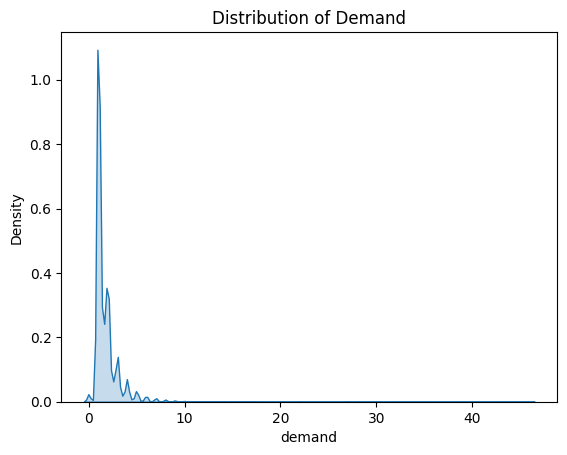

In [96]:
sns.kdeplot(hourly_demand['demand'], fill=True)
plt.title("Distribution of Demand")
plt.show()
